![portada](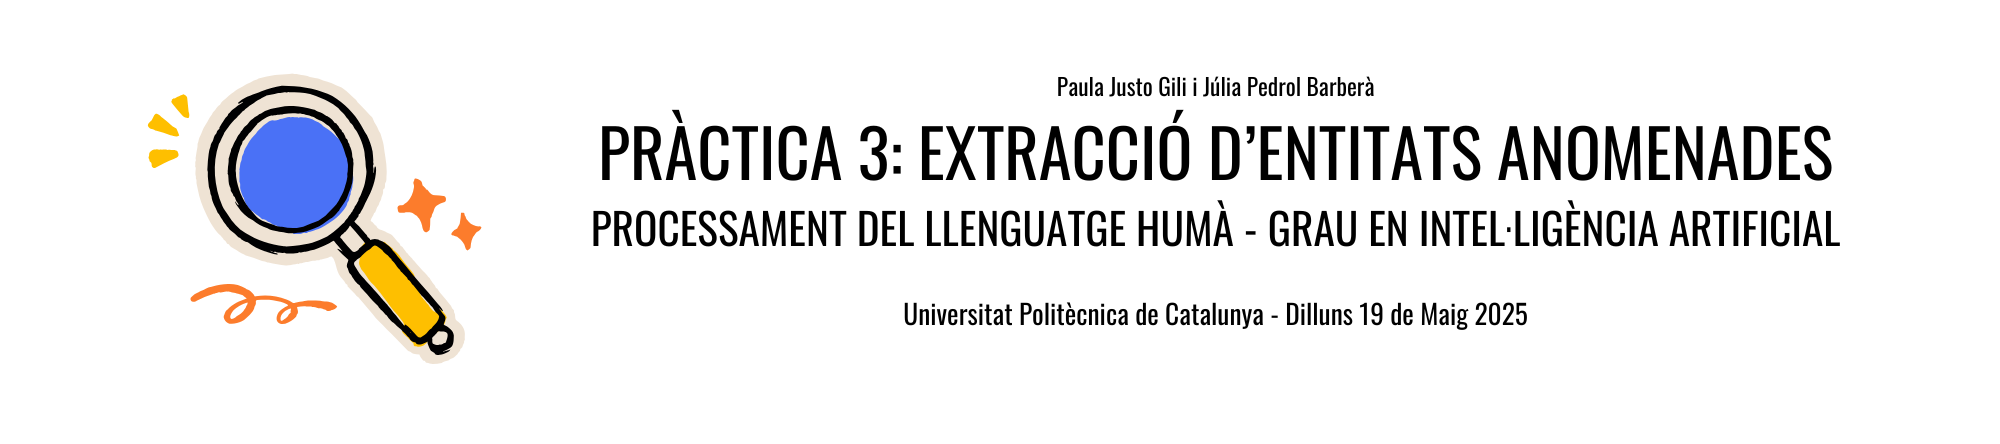
)

## **ÍNDEX**
- [INTRODUCCIÓ](#introducció)
- [PREPARACIÓ I DESCÀRREGA DE DADES](#preparació-i-descàrrega-de-dades)
- [1. Implementació del CRFTagger personalitzat](#1-implementació-del-crftagger-personalitzat)
    - [1.1. Classe FeatFunt per les Feature Functions](#11-classe-featfunc-per-les-feature-functions)
    - [1.2. Subclasse CostumCRFTagger](#12-subclasse-customcrftagger)
- [2. Entrenament Inicial de models per Espanyol i Neerlandès](#2-entrenament-inicial-de-models-per-espanyol-i-neerlandès)
    - [2.1. Carregar models](#21-carregar-models)
    - [2.2. Fer tagging sobre frases de test](#22-fer-tagging-sobre-frases-de-test)
    - [2.3. Funcions d'Avaluació i Extracció d'Entitats](#23-funcions-davaluació-i-extracció-dentitats)
        - [Reconstruir les entitats](#reconstruir-les-entitats)
        - [Avaluació real (presicion, recall, f1)](#avaluació-real-precision-recall-f1)
- [3. Experiments amb Feature Functions](#3-experiments-amb-feature-functions)
    - [3.1. Baseline i Configuracions Inicials](#31-baseline-i-configuracions-inicials)
- [4. Conversió entre Codificacions](#4-conversió-entre-codificacions)
    - [4.1. Funcions de Conversió de BIO a Altres Codificacions](#41-funcions-de-conversió-de-bio-a-altres-codificacions)
    - [4.2. Funcions per Tornar a BIO](#42-funcions-per-tornar-a-bio)
- [5. Comparació entre Codificacions](#5-comparació-entre-codificacions)
- [6. Cerca d'Hiperparàmetres (c1,c2)](#6-cerca-dhiperparàmetres-c1-c2)
- [7. Entrenament del Model Final](#7-entrenament-del-model-final)
    - [7.1. Entrenament i Guardat](#71-entrenament-i-guardat)
    - [7.2. Avaluació Final sobre el Test](#72-avaluació-final-sobre-el-test)
        - [Gràfica comparativa dels idiomes](#gràfica-comparativa-dels-idiomes)
- [8. Anàlisi dels Errors](#8-anàlisi-dels-errors)
- [9. Part Opcional: Model sobre el corpus CADEC](#9-part-opcional-model-sobre-el-corpus-cadec)

## **INTRODUCCIÓ**
---
En aquesta pràctica ens endinsarem en el reconeixement d'entitats anomenades (Named Entity Recognition, NER), una tasca fonamental en el processament del llenguatge natural (PLN). L’objectiu principal és implementar un sistema capaç d'identificar i classificar entitats dins d’un text, com ara persones, organitzacions o localitzacions, utilitzant models basats en *Conditional Random Fields* (CRF).

Per dur-ho a terme, farem ús del corpus *conll2002*, centrat en les llengües espanyola i neerlandesa, i entrenarem un model diferent per a cada llengua mitjançant la classe `nltk.tag.CRFTagger` del paquet `nltk`. A més d’emprar les característiques per defecte que proporciona aquesta eina, explorarem com la inclusió de noves *feature functions* —com ara prefixos, sufixos, etiquetes morfosintàctiques (POS), longituds o llistes de paraules específiques (*gazetteers*)— pot millorar el rendiment del sistema.

Un altre aspecte clau de la pràctica serà l’experimentació amb diferents codificacions de les etiquetes d’entitat, com ara BIO, BIOW i IO. Aquestes codificacions permeten representar la posició d’un token dins d’una entitat (inici, interior, fora), i tenen un impacte directe en la interpretació i avaluació dels resultats.

Finalment, el sistema entrenat s’avaluarà amb textos reals i es comentaran els resultats obtinguts. De manera opcional, es podrà aplicar el reconeixedor al corpus CADEC, especialitzat en entitats mèdiques (com efectes adversos, malalties o medicaments), adaptant les *features* segons les particularitats d’aquest nou domini.

Amb aquest conjunt d'experiments i anàlisis, es pretén obtenir una comprensió més profunda dels factors que influeixen en el rendiment dels sistemes NER i com ajustar-los per obtenir millors resultats en diferents escenaris.

## **PREPARACIÓ I DESCÀRREGA DE DADES**
---

In [1]:
%pip install --user -U nltk
%pip install --user -U numpy
%pip install svgling

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 66.2 kB/s eta 0:00:0000:0200:07m
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
from nltk.corpus import conll2002
import re

nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to /Users/paula/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


True

In [3]:
# ESPANYOL
train_es = conll2002.iob_sents('esp.train')   # Dades d'entrenament per a l'espanyol
dev_es   = conll2002.iob_sents('esp.testa')   # Dades de desenvolupament (validació) per a l'espanyol
test_es  = conll2002.iob_sents('esp.testb')   # Dades de test final per a l'espanyol

# NEERLANDÈS
train_nl = conll2002.iob_sents('ned.train')   # Dades d'entrenament per al neerlandès
dev_nl   = conll2002.iob_sents('ned.testa')   # Dades de desenvolupament (validació) per al neerlandès
test_nl  = conll2002.iob_sents('ned.testb')   # Dades de test final per al neerlandès

In [4]:
# Mirem la primera frase de cada text -> el format que tenim és [(token, pos, iob)]

print("\033[1mESPANYOL - Train (esp.train):\033[0m")
print(train_es[0])

print("\033[1mESPANYOL - Dev (esp.testa):\033[0m")
print(dev_es[0])

print("\033[1mESPANYOL - Test (esp.testb):\033[0m")
print(test_es[0])

print("\n\033[1mNEERLANDÈS - Train (ned.train):\033[0m")
print(train_nl[0])

print("\033[1mNEERLANDÈS - Dev (ned.testa):\033[0m")
print(dev_nl[0])

print("\033[1mNEERLANDÈS - Test (ned.testb):\033[0m")
print(test_nl[0])


ESPANYOL - Train (esp.train):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
ESPANYOL - Dev (esp.testa):
[('Sao', 'NC', 'B-LOC'), ('Paulo', 'VMI', 'I-LOC'), ('(', 'Fpa', 'O'), ('Brasil', 'NC', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('23', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFECOM', 'NP', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
ESPANYOL - Test (esp.testb):
[('La', 'DA', 'B-LOC'), ('Coruña', 'NC', 'I-LOC'), (',', 'Fc', 'O'), ('23', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFECOM', 'NP', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

NEERLANDÈS - Train (ned.train):
[('De', 'Art', 'O'), ('tekst', 'N', 'O'), ('van', 'Prep', 'O'), ('het', 'Art', 'O'), ('arrest', 'N', 'O'), ('is', 'V', 'O'), ('nog', 'Adv', 'O'), ('niet', 'Adv', 'O'), ('schriftelijk', 'Adj', 'O'), (

## **1. Implementació del CRFTagger Personalitzat**

### **1.1. Classe FeatFunc per les Feature Functions**

Per tal de generar les característiques que alimenten el model CRF, vam definir la classe `FeatFunc`, que ens permet controlar de manera flexible quins tipus de features incloure per a cada token. Aquesta classe ens facilita experimentar amb combinacions de característiques lèxiques, morfològiques, sintàctiques (POS) i contextuals, així com consultar gazetteers específics per identificar entitats conegudes. Aquesta modularitat és clau per optimitzar el rendiment del model i adaptar-lo a diferents llengües o contextos.

In [5]:
import re
from typing import List
from unidecode import unidecode
import pycrfsuite

class FeatFunc:
    """
    Classe FeatFunc per a la generació de feature functions.

    Aquesta classe permet definir i aplicar un conjunt configurable de característiques (features) per a cada token en una seqüència,
    amb l'objectiu d'entrenar un model de tipus Conditional Random Field (CRF) mitjançant la biblioteca NLTK/pycrfsuite.

    Paràmetres del constructor:
    - use_word (bool): Inclou la paraula original com a feature.
    - use_upper (bool): Indica si la primera lletra és majúscula.
    - use_digit (bool): Detecta si la paraula conté dígits.
    - use_punct (bool): Detecta si la paraula conté signes de puntuació.
    - use_suf (bool): Afegeix els tres darrers caràcters (sufix).
    - use_pref (bool): Afegeix els tres primers caràcters (prefix).
    - use_len (bool): Afegeix la longitud de la paraula.
    - use_pos (bool): Inclou l’etiqueta morfosintàctica (POS) si està disponible.
    - use_context (bool): Afegeix informació del context (paraula anterior i següent, BOS/EOS).
    - gazetteer (set): Conjunt de paraules rellevants que, si hi són, activen una feature específica (gazetteer lookup).

    Mètode __call__(tokens: List[str], idx: int) -> List[str]:
    - Genera i retorna una llista de cadenes amb les característiques del token en la posició `idx` dins la seqüència `tokens`.
    - Inclou també característiques del context immediat si està activat.

    Aquesta classe està pensada per facilitar l’experimentació amb combinacions de features per millorar el rendiment
    del model NER, i permet una alta flexibilitat per a proves sistemàtiques dins el marc de la pràctica 3.
    """

    def __init__(
        self,
        use_word=True,
        use_upper=True,
        use_digit=True,
        use_punct=True,
        use_suf=True,
        use_pref=True,
        use_len=False,
        use_pos=False,
        use_context=True,
        gazetteer=None
    ):
        self.use_word = use_word
        self.use_upper = use_upper
        self.use_digit = use_digit
        self.use_punct = use_punct
        self.use_suf = use_suf
        self.use_pref = use_pref
        self.use_len = use_len
        self.use_pos = use_pos
        self.use_context = use_context
        self.gazetteer = gazetteer or set()

    def __call__(self, tokens: List[str], idx: int) -> List[str]:
        feats = []

        token = tokens[idx]
        word = token[0] if isinstance(token, tuple) else token
        pos = token[1] if isinstance(token, tuple) and len(token) > 1 else ""

        if self.use_word:
            feats.append(f"word={word}")

        if self.use_upper:
            feats.append(f"is_upper={word[0].isupper()}")

        if self.use_digit:
            feats.append(f"has_digit={any(char.isdigit() for char in word)}")

        if self.use_punct:
            has_punct = bool(re.search(r'[^\w\s]', word))
            feats.append(f"has_punct={has_punct}")

        if self.use_suf:
            feats.append(f"suf={word[-3:]}")

        if self.use_pref:
            feats.append(f"pref={word[:3]}")

        if self.use_len:
            feats.append(f"len={len(word)}")

        if self.use_pos and pos:
            feats.append(f"pos={pos}")

        # Millora: normalitzar la paraula abans de buscar al gazetteer
        word_normalized = unidecode(word.lower())
        if word_normalized in self.gazetteer:
            feats.append("in_gazetteer=True")

        # CONTEXTUAL FEATURES
        if self.use_context:
            if idx > 0:
                prev_token = tokens[idx - 1]
                prev_word = prev_token[0] if isinstance(prev_token, tuple) else prev_token
                feats.append(f"prev_word={prev_word}")
                if self.use_pos:
                    prev_pos = prev_token[1] if isinstance(prev_token, tuple) and len(prev_token) > 1 else ""
                    feats.append(f"prev_pos={prev_pos}")
            else:
                feats.append("BOS")  # Begin Of Sentence

            if idx < len(tokens) - 1:
                next_token = tokens[idx + 1]
                next_word = next_token[0] if isinstance(next_token, tuple) else next_token
                feats.append(f"next_word={next_word}")
                if self.use_pos:
                    next_pos = next_token[1] if isinstance(next_token, tuple) and len(next_token) > 1 else ""
                    feats.append(f"next_pos={next_pos}")
            else:
                feats.append("EOS")  # End Of Sentence

        return feats


### **1.2. Subclasse CustomCRFTagger**

Per tal de poder aplicar les funcions de característiques personalitzades al nostre model de CRF, vam estendre la classe CRFTagger de NLTK mitjançant una subclasse anomenada `CustomCRFTagger`. Aquesta modificació ens permet connectar fàcilment qualsevol funció de features —com la classe FeatFunc definida prèviament— i mantenir la modularitat del codi. Això facilita tant l’experimentació com la reutilització dels components al llarg de la pràctica.

In [6]:
from nltk.tag import CRFTagger

class CustomCRFTagger(CRFTagger):
    """
    Classe CustomCRFTagger, una subclasse de nltk.tag.CRFTagger amb suport per a funcions de features personalitzades.

    Aquesta classe permet integrar de manera flexible una funció de generació de features definida externament
    en el procés d'entrenament i etiquetatge d’un model CRF. La motivació principal és facilitar l'experimentació
    amb diferents estratègies de representació de tokens (feature engineering), essencial per a millorar el rendiment
    en tasques de reconeixement d'entitats anomenades (NER).

    Paràmetres del constructor:
    - feature_func (callable): Funció o objecte callable que rep una seqüència de tokens i un índex, i retorna una
    llista de features per al token corresponent.

    Comportament:
    - Sobreescriu el mètode intern _feature_func per redirigir les crides cap a una funció definida per l’usuari.
    - Si no es proporciona cap feature_func, utilitza el comportament per defecte de la classe base.

    Mètodes:
    - _custom_feature_func(tokens, index): Crida a la funció de *features* proporcionada o bé a la funció per defecte
    del CRFTagger si no n’hi ha cap.

    Exemple d’ús:
        tagger = CustomCRFTagger(feature_func=feat_func)
        tagger.train(train_data, model_file)

    Aquesta extensió és útil per mantenir la modularitat i afavorir la reutilització de components
    durant la pràctica 3.
    """

    def __init__(self, feature_func=None):
        super().__init__()
        self._feature_func = self._custom_feature_func  # Sobreescriu el comportament intern
        self.feature_func = feature_func                # Guarda la funció de features

    def _custom_feature_func(self, tokens, index):
        if self.feature_func:
            return self.feature_func(tokens, index)
        else:
            return super()._get_features(tokens, index, history=[])


## **2. Entrenament Inicial de Models per Espanyol i Neerlandès**

In [7]:
def carregar_llista(path):
    """
    Funció carregar_llista

    Carrega una llista de paraules des d’un fitxer de text i la retorna com un conjunt (set) de paraules en minúscules.

    Cada línia del fitxer es considera una entrada. Les línies buides s’ignoren i es fa *strip* dels espais en blanc. 
    La normalització a minúscules permet comparacions més robustes, especialment útils per al lookup en gazetteers.

    Paràmetres:
    - path (str): Ruta al fitxer de text que conté una paraula per línia.

    Retorna:
    - Set[str]: Conjunt de paraules netes i en minúscules.
    """

    with open(path, encoding='utf-8') as f:
        return set(line.strip().lower() for line in f if line.strip())

gazetteer = {
    "cities": carregar_llista("cities50000.txt"),
    "company": carregar_llista("companies.txt"),
    "celebrity": carregar_llista("celebrities.txt"),
    "surname_esp": carregar_llista("surnames_esp.txt"),
    "surname_nl": carregar_llista("surnames_ned.txt"),
    "names_esp": carregar_llista("names500_esp.txt"),
    "organizations_esp": carregar_llista("research_organizations_esp.txt"),
    "organizations_nl": carregar_llista("research_organizations_ned.txt")
}


Per a l’entrenament del model en espanyol, primer vam preparar les dades transformant cada frase en una llista de tuples amb la forma `((token, pos), tag)`, que combina la paraula amb la seva categoria gramatical i l’etiqueta d’entitat. Tot seguit, vam instanciar el model CustomCRFTagger amb les funcions de característiques definides a `feat_func_esp`, i vam entrenar el model utilitzant aquestes dades. Finalment, vam guardar el model entrenat en un fitxer per poder reutilitzar-lo posteriorment.

In [8]:
feat_func_esp = FeatFunc(
    use_word=True,            # Inclou la paraula original com a feature
    use_upper=True,           # Inclou si la paraula comença en majúscula (útil per detectar noms propis)
    use_digit=True,           # Detecta si hi ha dígits (pot identificar codis, dates, etc.)
    use_punct=True,           # Detecta signes de puntuació (pot indicar final de frase o entitat especial)
    use_suf=True,             # Inclou sufixos (ex: -ció, -ista... útil per tipus de paraula)
    use_pref=True,            # Inclou prefixos (ex: re-, pre-, sub-...)
    use_len=True,             # Inclou la longitud de la paraula (pot ser útil per discriminar abreviatures, etc.)
    use_pos=True,             # Utilitza la categoria gramatical (POS) de la paraula (nom, verb, etc.)
    use_context=True,         # Afegeix context (paraules anteriors i posteriors)
    gazetteer={
        "cities": gazetteer["cities"],                 
        "company": gazetteer["company"],               
        "celebrity": gazetteer["celebrity"],           
        "surname": gazetteer["surname_esp"],          
        "names": gazetteer["names_esp"],               
        "organizations": gazetteer["organizations_esp"]
    }
)


In [9]:
%pip install python-crfsuite

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Preparar les dades d'entrenament: ((token, pos), tag)
train_data_es = [[((w, pos), tag) for (w, pos, tag) in frase] for frase in train_es]

# Instanciar el tagger amb les feature functions
tagger_es = CustomCRFTagger(feature_func=feat_func_esp)

# Entrenar i guardar el model
tagger_es.train(train_data_es, 'model_esp.crf.tagger')

Per al cas del neerlandès, vam definir una nova funció de característiques adaptada (`feat_func_nl`) que reutilitza l’esquema general anterior, però fa ús dels gazetteers específics per a cognoms i organitzacions d’aquest idioma. Això permet al model capturar millor les entitats pròpies del context lingüístic neerlandès.

In [11]:
# Crear la funció de features amb POS inclòs
feat_func_nl = FeatFunc(
    use_word=True,
    use_upper=True,
    use_digit=True,
    use_punct=True,
    use_suf=True,
    use_pref=True,
    use_len=True,
    use_pos=True,  
    use_context=True,
    gazetteer={
        "cities": gazetteer["cities"],
        "company": gazetteer["company"],
        "celebrity": gazetteer["celebrity"],
        "surname": gazetteer["surname_nl"],
        "organizations": gazetteer["organizations_nl"]
    }
)

In [12]:
# Preparar les dades d'entrenament: ((token, pos), tag)
train_data_nl = [[((w, pos), tag) for (w, pos, tag) in frase] for frase in train_nl]

# Instanciar el tagger amb les mateixes feature functions
tagger_nl = CustomCRFTagger(feature_func=feat_func_nl)

# Entrenar i guardar el model
tagger_nl.train(train_data_nl, 'model_nl.crf.tagger')

### **2.1. Carregar models**

In [13]:
# Carregar el model espanyol amb les mateixes features de l'entrenament
tagger_es_loaded = CustomCRFTagger(feature_func=feat_func_esp)
tagger_es_loaded.set_model_file('model_esp.crf.tagger')

# Carregar el model neerlandès amb les features corresponents
tagger_nl_loaded = CustomCRFTagger(feature_func=feat_func_nl)
tagger_nl_loaded.set_model_file('model_nl.crf.tagger')

### **2.2. Fer tagging sobre frases de test**

Un cop entrenats i carregats els models, vam preparar les dades de validació per a cada idioma. Per a això, vam extreure els parells `(token, pos)` necessaris per fer les prediccions, i vam guardar per separat els parells `(token, tag)` reals per poder comparar les etiquetes assignades pel model amb les etiquetes correctes durant l’avaluació.

In [14]:
# Preparar frases de test espanyol (tokens + pos)
val_data_es = [[(w, pos) for (w, pos, tag) in frase] for frase in dev_es]
real_tags_es = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_es]

# Preparar frases de test neerlandès (tokens + pos)
val_data_nl = [[(w, pos) for (w, pos, tag) in frase] for frase in dev_nl]
real_tags_nl = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_nl]

In [15]:
# Exemple de tagging sobre la primera frase del test espanyol
prediccio_es = tagger_es_loaded.tag(val_data_es[0])
print('\033[1mPredicció Espanyol\033[0m')
print(prediccio_es)

# Exemple de tagging sobre la primera frase del test neerlandès
prediccio_nl = tagger_nl_loaded.tag(val_data_nl[0])
print('\n\033[1mPredicció Neerlandès\033[0m')
print(prediccio_nl)

Predicció Espanyol
[(('Sao', 'NC'), 'B-LOC'), (('Paulo', 'VMI'), 'I-LOC'), (('(', 'Fpa'), 'O'), (('Brasil', 'NC'), 'B-LOC'), ((')', 'Fpt'), 'O'), ((',', 'Fc'), 'O'), (('23', 'Z'), 'O'), (('may', 'NC'), 'O'), (('(', 'Fpa'), 'O'), (('EFECOM', 'NP'), 'B-ORG'), ((')', 'Fpt'), 'O'), (('.', 'Fp'), 'O')]

Predicció Neerlandès
[(('Dat', 'Pron'), 'O'), (('is', 'V'), 'O'), (('verder', 'Adj'), 'O'), (('opgelaaid', 'N'), 'O'), (('door', 'Prep'), 'O'), (('windsnelheden', 'N'), 'O'), (('die', 'Pron'), 'O'), (('oplopen', 'V'), 'O'), (('tot', 'Prep'), 'O'), (('35', 'Num'), 'O'), (('kilometer', 'N'), 'O'), (('per', 'Prep'), 'O'), (('uur', 'N'), 'O'), (('.', 'Punc'), 'O')]


Per validar el funcionament dels models entrenats, vam aplicar-los a la primera frase del conjunt de validació de cada idioma. En la sortida es pot observar com cada token és etiquetat amb la seva categoria morfosintàctica (POS) i l’etiqueta d’entitat corresponent en format BIO. Per exemple, en espanyol, el model detecta correctament Sao i Paulo com a part de l’entitat geogràfica LOC, i Brasil com una nova entitat del mateix tipus.
En el cas del neerlandès, la predicció mostra un etiquetatge coherent on la majoria de tokens són classificats com a fora d’entitat (O), fet esperable si la frase no conté noms propis destacables.
Aquest tipus de visualització ens permet fer una primera inspecció qualitativa del comportament del model i verificar si aprèn patrons útils per identificar entitats reals dins el text.

### **2.3. Funcions d'Avaluació i Extracció d'Entitats**

#### Reconstruir les entitats

Per tal d’avaluar el rendiment del model en reconeixement d’entitats, vam implementar una funció que extreu les entitats identificades en una seqüència anotada amb etiquetes BIO. Això ens permet comparar les entitats previstes amb les reals de manera precisa.

In [16]:
def get_entities(seq):
    """
    Donada una seqüència d'etiquetes amb el format [(token, etiqueta)],
    retorna una llista de tuples amb les entitats extretes.
    
    Cada entitat es representa com una tupla (inici, final, tipus), indicant
    la posició inicial i final dins la seqüència, així com el tipus d’entitat 
    (ex: PER, LOC, ORG). Es basa en el format BIO: B- per començament, 
    I- per continuació, i O per cap entitat.
    """
    entities = []
    start = None
    entity_type = None

    for idx, (token, tag) in enumerate(seq):
        if tag.startswith('B-'):
            if start is not None:
                entities.append((start, idx - 1, entity_type))
            start = idx
            entity_type = tag[2:]
        elif tag.startswith('I-'):
            if start is None:
                start = idx
                entity_type = tag[2:]
        else:  # tag == 'O'
            if start is not None:
                entities.append((start, idx - 1, entity_type))
                start = None
                entity_type = None

    # Capturar l'última entitat si acaba just al final
    if start is not None:
        entities.append((start, len(seq) - 1, entity_type))

    return entities

#### Avaluació real (precision, recall, F1)

Per avaluar la qualitat del reconeixement d'entitats, vam implementar dues funcions: `entity_overlap`, que comprova si dues entitats del mateix tipus se solapen parcialment, i `evaluate`, que calcula mètriques de precisió, recall i F1 tant per coincidències exactes com per coincidències que inclouen solapaments parcials.
Aquesta avaluació ens permet mesurar la capacitat del model no només per identificar correctament les entitats completes, sinó també per reconèixer parcialment entitats correctes, la qual cosa és rellevant en aplicacions pràctiques com l'extracció d'informació.

In [17]:
def entity_overlap(ent1, ent2):
    """
    Comprova si dues entitats se solapen (parcialment).
    entitats són tuples (start, end, label)
    """
    start1, end1, label1 = ent1
    start2, end2, label2 = ent2
    return label1 == label2 and max(start1, start2) < min(end1, end2)

In [18]:
def evaluate(true_seqs, pred_seqs):
    """
    Avalua la qualitat en termes d'entitats:
    - Coincidències exactes
    - Coincidències exactes + parcials

    Retorna:
    - {'exact': (prec, rec, f1), 'partial': (prec, rec, f1)}
    """
    true_entities = set()
    pred_entities = set()

    for true_seq in true_seqs:
        true_entities.update(get_entities(true_seq))

    for pred_seq in pred_seqs:
        pred_entities.update(get_entities(pred_seq))

    # Coincidències exactes
    exact_matches = true_entities & pred_entities

    # Coincidències parcials (no exactes)
    partial_matches = set()
    remaining_true = true_entities - exact_matches
    remaining_pred = pred_entities - exact_matches

    for pred_ent in remaining_pred:
        for true_ent in remaining_true:
            if entity_overlap(pred_ent, true_ent):
                partial_matches.add(pred_ent)
                break

    # Mètriques exactes
    exact_precision = len(exact_matches) / len(pred_entities) if pred_entities else 0
    exact_recall = len(exact_matches) / len(true_entities) if true_entities else 0
    exact_f1 = (2 * exact_precision * exact_recall / (exact_precision + exact_recall)
                if (exact_precision + exact_recall) else 0)

    # Mètriques amb parcials
    total_correct = len(exact_matches) + len(partial_matches)
    partial_precision = total_correct / len(pred_entities) if pred_entities else 0
    partial_recall = total_correct / len(true_entities) if true_entities else 0
    partial_f1 = (2 * partial_precision * partial_recall / (partial_precision + partial_recall)
                  if (partial_precision + partial_recall) else 0)

    return {
        'exact': (exact_precision, exact_recall, exact_f1),
        'partial': (partial_precision, partial_recall, partial_f1)
    }


In [19]:
# Fer tagging a tot el conjunt de test espanyol
preds_es = [tagger_es_loaded.tag(sent) for sent in val_data_es]

# Convertir també les frases reals
reals_es = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_es]

# Avaluar amb la nova funció
results_es = evaluate(reals_es, preds_es)

# Separar els resultats
precision_exact, recall_exact, f1_exact = results_es['exact']
precision_partial, recall_partial, f1_partial = results_es['partial']

# Mostrar
print('\033[1mAvaluació Espanyol\033[0m\n')

print('\033[1m-- Coincidències Exactes --\033[0m')
print(f"Precision: {precision_exact:.4f}")
print(f"Recall: {recall_exact:.4f}")
print(f"F1: {f1_exact:.4f}\n")

print('\033[1m-- Coincidències Exactes + Parcials --\033[0m')
print(f"Precision: {precision_partial:.4f}")
print(f"Recall: {recall_partial:.4f}")
print(f"F1: {f1_partial:.4f}")

Avaluació Espanyol

-- Coincidències Exactes --
Precision: 0.8552
Recall: 0.8248
F1: 0.8397

-- Coincidències Exactes + Parcials --
Precision: 0.9563
Recall: 0.9224
F1: 0.9391


Un cop etiquetades totes les frases del conjunt de test en espanyol, vam avaluar el rendiment del model comparant les etiquetes predites amb les etiquetes reals. L’avaluació es va fer utilitzant dues estratègies:

- **Coincidències exactes**: només compten aquelles entitats que coincideixen completament amb la seva posició i tipus.
- **Coincidències exactes + parcials**: també consideren correctes les entitats que se solapen parcialment amb una entitat real del mateix tipus.

Els resultats mostren que el model obté un bon rendiment, amb una **precisió del 85,5%** i un **F1 de 83,9%** en l’avaluació estricta, i una **precisió del 95,6%** i un **F1 del 93,9%** quan es permeten coincidències parcials. Això indica que el model reconeix adequadament la majoria d’entitats, fins i tot si alguna delimitació exacta falla lleugerament.


In [20]:
# Fer tagging a tot el conjunt de test neerlandès
preds_nl = [tagger_nl_loaded.tag(sent) for sent in val_data_nl]

# Convertir també les frases reals
reals_nl = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_nl]

# Avaluar amb la nova funció
results_nl = evaluate(reals_nl, preds_nl)

# Separar els resultats
precision_exact_nl, recall_exact_nl, f1_exact_nl = results_nl['exact']
precision_partial_nl, recall_partial_nl, f1_partial_nl = results_nl['partial']

# Mostrar
print('\033[1mAvaluació Neerlandès\033[0m\n')

print('\033[1m-- Coincidències Exactes --\033[0m')
print(f"Precision: {precision_exact_nl:.4f}")
print(f"Recall: {recall_exact_nl:.4f}")
print(f"F1: {f1_exact_nl:.4f}\n")

print('\033[1m-- Coincidències Exactes + Parcials --\033[0m')
print(f"Precision: {precision_partial_nl:.4f}")
print(f"Recall: {recall_partial_nl:.4f}")
print(f"F1: {f1_partial_nl:.4f}")

Avaluació Neerlandès

-- Coincidències Exactes --
Precision: 0.8484
Recall: 0.8395
F1: 0.8439

-- Coincidències Exactes + Parcials --
Precision: 0.9388
Recall: 0.9289
F1: 0.9339


Per al cas del neerlandès, vam aplicar el mateix procediment d’avaluació. El model es va posar a prova amb tot el conjunt de test i es van calcular les mètriques de precisió, recall i F1, tant per coincidències exactes com per solapaments parcials. 

Aquesta anàlisi ens permet comparar el comportament del model entre llengües i valorar la seva capacitat de generalització sobre textos en neerlandès.

Els resultats del model per al neerlandès mostren un comportament molt consistent amb el cas de l'espanyol. Amb una **precisió del 84,8%** i un **F1 de 84,4%** en coincidències exactes, el model demostra una bona capacitat per identificar entitats amb gran exactitud.

Quan s’inclouen també les coincidències parcials, el rendiment millora significativament, arribant a una **precisió del 93,9%** i un **F1 del 93,4%**. Això indica que, fins i tot en casos on la delimitació exacta de l’entitat pot variar lleugerament, el model continua identificant correctament les entitats rellevants. 

En conjunt, aquestes mètriques reflecteixen un model robust i ben generalitzat per a l’etiquetatge d’entitats en llengua neerlandesa.


## **3. Experiments amb Feature Functions**

### **3.1. Baseline i Configuracions Inicials**

Amb l’objectiu de valorar la contribució real de les *features* dissenyades, vam definir un model baseline simplificat per a l’espanyol. Aquesta configuració mínima només inclou característiques molt bàsiques: si la paraula comença amb majúscula i si conté dígits. No es fan servir ni el token original, ni el context, ni cap gazetteer, ni etiquetes morfosintàctiques (POS).

Aquest model de referència ens permet mesurar fins a quin punt les *features* més avançades (com els prefixos/sufixos, el context o l’ús de llistes externes) milloren el rendiment. Els resultats del baseline serveixen així com a punt de partida per justificar l’eficàcia de les millores proposades al model complet.


In [21]:
# BASELINE ESPANYOL
baseline_config_es = {
    "use_word": False,
    "use_upper": True,
    "use_digit": True,
    "use_punct": False,
    "use_suf": False,
    "use_pref": False,
    "use_len": False,
    "use_pos": False,
    "use_context": False,
    "gazetteer": None
}

feat_func_baseline_es = FeatFunc(**baseline_config_es)
tagger_baseline_es = CustomCRFTagger(feature_func=feat_func_baseline_es)
tagger_baseline_es.train(train_data_es, "model_esp_baseline.model")
tagger_baseline_es.set_model_file("model_esp_baseline.model")

# Prediccions
preds_baseline_es = [tagger_baseline_es.tag(sent) for sent in val_data_es]

# Avaluació
results_baseline_es = evaluate(real_tags_es, preds_baseline_es)
precision_baseline_es, recall_baseline_es, f1_baseline_es = results_baseline_es['exact']
precision_baseline_partial_es, recall_baseline_partial_es, f1_baseline_partial_es = results_baseline_es['partial']

# Impressió de resultats
print("\033[1mBASELINE ESPANYOL\033[0m")
print(f"→ [Exactes]   Precision: {precision_baseline_es:.4f} | Recall: {recall_baseline_es:.4f} | F1: {f1_baseline_es:.4f}")
print(f"→ [Parcials]  Precision: {precision_baseline_partial_es:.4f} | Recall: {recall_baseline_partial_es:.4f} | F1: {f1_baseline_partial_es:.4f}")

BASELINE ESPANYOL
→ [Exactes]   Precision: 0.5690 | Recall: 0.2561 | F1: 0.3532
→ [Parcials]  Precision: 0.9138 | Recall: 0.4113 | F1: 0.5673


Els resultats obtinguts posen de manifest la importància de la selecció i disseny de les *features* per a un sistema de reconeixement d'entitats amb CRF. El model complet per a l’espanyol aconsegueix un **F1 del 83,9%** amb coincidències exactes, mentre que amb tolerància a coincidències parcials s’eleva fins al **93,9%**. En el cas del neerlandès, les mètriques són molt similars, amb un **F1 del 84,4%** (exacte) i un **93,4%** (parcial), cosa que demostra una bona generalització entre llengües.

En canvi, el **model baseline** per a l’espanyol, que només utilitza dues característiques bàsiques (majúscules i dígits), mostra un rendiment molt inferior: només **35,3% de F1** en coincidències exactes, tot i mantenir una **precisió elevada en coincidències parcials** (91,4%), però amb un **recall molt baix (41,1%)**. Això confirma que les *features* avançades (com POS, context, prefixos/sufixos i gazetteers) són essencials per capturar correctament els patrons d'entitat i reduir falsos negatius.

Aquest conjunt de resultats valida l’enfocament modular i progressiu adoptat durant el desenvolupament, i destaca la rellevància de l’enginyeria de *features* en tasques de NER.


--------------------------------------------------------------------------------------------------------------------------------------------------------------

Abans de fer una selecció automàtica del millor model o estratègia, vam estructurar el *gazetteer* per a l’espanyol en un diccionari per facilitar la seva consulta per categories específiques (empreses, celebritats, cognoms...). Això permet experimentar amb l’activació selectiva de fonts externes d’informació.

A més, vam definir la funció `get_f1s`, que extreu només els valors F1 de les mètriques exactes i parcials a partir del diccionari de resultats generat per la funció d’avaluació. Aquesta funció és útil per comparar fàcilment múltiples configuracions sense haver de revisar manualment cada bloc de mètriques.

Finalment, la variable `selection_mode` ens permet controlar el criteri de selecció durant l’experimentació (`exact`, `partial` o combinat), facilitant la comparació sistemàtica entre models en funció de l’estratègia d’avaluació escollida.


In [22]:
# Carregar gazetteer estructurat per espanyol
gazetteer_dict_esp = {
    "company": gazetteer["company"],
    "celebrity": gazetteer["celebrity"],
    "surname": gazetteer["surname_esp"]
}

In [23]:
def get_f1s(result_dict):
    """
    Retorna els F1 scores de coincidències exactes i parcials.
    Retorna un diccionari: {'exact': f1_exact, 'partial': f1_partial}
    """
    _, _, f1_exact = result_dict.get('exact', (0, 0, 0))
    _, _, f1_partial = result_dict.get('partial', (0, 0, 0))
    return {
        'exact': f1_exact,
        'partial': f1_partial
    }

In [24]:
selection_mode = 'exact'  # 'exact', 'partial' o 'mixed'

Amb l’objectiu d’optimitzar el conjunt de *features* utilitzades pel model CRF en espanyol, vam implementar una estratègia de cerca **greedy** (avara) per afegir, pas a pas, aquelles característiques que realment aporten millores mesurables.

1. **Configuració inicial**: vam definir una configuració base molt simple (semblant a un baseline), amb només majúscules, dígits i sufixos com a *features* actives.

2. **Llista de possibles millores**: es va preparar una llista de *features* opcionals (com context, POS, prefixos, gazetteers...) que s’anirien activant de manera incremental, una a una.

3. **Avaluació iterativa**:
    - En cada pas, s’activa una *feature* nova no provada fins ara.
    - Es torna a entrenar i avaluar el model sobre el conjunt de validació.
    - S’escull la *feature* que aporta la millor millora respecte a la configuració anterior, segons el criteri seleccionat (`exact`, `partial` o `mixed`).

4. **Criteri de parada**: el procés continua mentre s’obtinguin millores. Quan cap *feature* afegida no millora el rendiment, la cerca s’atura.

5. **Sortida final**: es mostra la configuració òptima trobada i el F1 score obtingut.

Aquesta estratègia permet fer una **selecció sistemàtica i justificada** de les característiques més rellevants per a la llengua espanyola, evitant tant la sobrecàrrega de features com l’ús de característiques poc útils.


In [25]:
# --- CONFIGURACIÓ INICIAL ---
base_config = {
    "use_word": False,
    "use_upper": True,
    "use_digit": True,
    "use_punct": False,
    "use_suf": True,
    "use_pref": False,
    "use_len": False,
    "use_pos": False,
    "use_context": False,
    "gazetteer": None  
}

possible_keys = ["use_word", "use_punct", "use_pref", "use_len", "use_pos", "use_context", "gazetteer"]
used_keys = set()
best_config_esp = base_config.copy()

# Avaluació inicial
feat_func = FeatFunc(**best_config_esp)
tagger = CustomCRFTagger(feature_func=feat_func)
tagger.train(train_data_es, "temp_base_esp.model")
tagger.set_model_file("temp_base_esp.model")
preds = [tagger.tag(sent) for sent in val_data_es]
results = evaluate(real_tags_es, preds)
f1_scores = get_f1s(results)

# Punt de partida segons el mode seleccionat
if selection_mode == 'mixed':
    best_score = (f1_scores['exact'] + f1_scores['partial']) / 2
else:
    best_score = f1_scores[selection_mode]

print(f"\033[1m[INICI - ESPANYOL] Configuració bàsica:\033[0m\n{best_config_esp}")
print(f"→ F1 inicial [exacte]: {f1_scores['exact']:.4f} | [parcial]: {f1_scores['partial']:.4f}")

# --- CERCA GREEDY ---
step = 1
while True:
    print(f"\n\033[1mPAS {step}: afegir nova feature\033[0m")
    found_better = False
    best_trial_config = None
    best_trial_score = best_score
    best_feature = None

    for key in possible_keys:
        if key in used_keys:
            continue

        trial_config = best_config_esp.copy()
        if key == "gazetteer":
            trial_config["gazetteer"] = gazetteer_dict_esp  
        else:
            trial_config[key] = True

        feat_func = FeatFunc(**trial_config)
        tagger = CustomCRFTagger(feature_func=feat_func)
        tagger.train(train_data_es, f"temp_trial_esp_{key}.model")
        tagger.set_model_file(f"temp_trial_esp_{key}.model")
        preds = [tagger.tag(sent) for sent in val_data_es]
        results = evaluate(real_tags_es, preds)
        f1_scores = get_f1s(results)

        # Escollir mètrica segons mode
        if selection_mode == 'mixed':
            trial_score = (f1_scores['exact'] + f1_scores['partial']) / 2
        else:
            trial_score = f1_scores[selection_mode]

        print(f"→ Provat afegint '{key}': F1 [exacte] = {f1_scores['exact']:.4f} | [parcial] = {f1_scores['partial']:.4f}")

        if trial_score > best_trial_score:
            best_trial_score = trial_score
            best_trial_config = trial_config
            best_feature = key
            found_better = True

    if found_better:
        print(f"\n\033[1mMillora trobada:\033[0m afegint '{best_feature}' → Score = {best_trial_score:.4f}")
        best_config_esp = best_trial_config
        best_score = best_trial_score
        used_keys.add(best_feature)
        step += 1
    else:
        print("\n\033[1;91mCap millora trobada. Aturant cerca.\033[0m")
        break

# --- RESULTAT FINAL ---
print("\n\033[1mCONFIGURACIÓ ÒPTIMA FINAL (ESPANYOL)\033[0m")
print(best_config_esp)
print(f"\033[1m→ Score final ({selection_mode}): {best_score:.4f}\033[0m")

[INICI - ESPANYOL] Configuració bàsica:
{'use_word': False, 'use_upper': True, 'use_digit': True, 'use_punct': False, 'use_suf': True, 'use_pref': False, 'use_len': False, 'use_pos': False, 'use_context': False, 'gazetteer': None}
→ F1 inicial [exacte]: 0.7728 | [parcial]: 0.9100

PAS 1: afegir nova feature
→ Provat afegint 'use_word': F1 [exacte] = 0.8007 | [parcial] = 0.9242
→ Provat afegint 'use_punct': F1 [exacte] = 0.7741 | [parcial] = 0.9082
→ Provat afegint 'use_pref': F1 [exacte] = 0.8106 | [parcial] = 0.9331
→ Provat afegint 'use_len': F1 [exacte] = 0.7755 | [parcial] = 0.9181
→ Provat afegint 'use_pos': F1 [exacte] = 0.7738 | [parcial] = 0.9140
→ Provat afegint 'use_context': F1 [exacte] = 0.8153 | [parcial] = 0.9268
→ Provat afegint 'gazetteer': F1 [exacte] = 0.7728 | [parcial] = 0.9100

Millora trobada: afegint 'use_context' → Score = 0.8153

PAS 2: afegir nova feature
→ Provat afegint 'use_word': F1 [exacte] = 0.8301 | [parcial] = 0.9325
→ Provat afegint 'use_punct': F1 [e

La cerca greedy va començar amb una configuració bàsica que incloïa només les *features* `use_upper`, `use_digit` i `use_suf`, obtenint un F1 inicial de **0.7728** (exacte) i **0.9100** (parcial).

A partir d’aquest punt, es van afegir progressivament *features* candidates, una a una, seleccionant en cada pas la que aportava una millora més gran segons el criteri `exact`. A continuació es detalla l’evolució:

- **Pas 1:** s’afegeix `use_context`, que aporta una millora clara fins a **F1 = 0.8153**.
- **Pas 2:** s’afegeix `use_word`, incrementant l’F1 a **0.8301**.
- **Pas 3:** s’incorpora `use_pref`, que eleva l’F1 a **0.8332**.
- **Pas 4:** afegint `use_pos`, l’F1 puja a **0.8401**.
- **Pas 5:** amb `use_punct`, s’assoleix el millor resultat, **F1 = 0.8407**.
- **Pas 6:** cap de les *features* restants (`use_len`, `gazetteer`) aporta millores, i la cerca s’atura.

**Configuració final òptima trobada:**

```python
{
    "use_word": True,
    "use_upper": True,
    "use_digit": True,
    "use_punct": True,
    "use_suf": True,
    "use_pref": True,
    "use_len": False,
    "use_pos": True,
    "use_context": True,
    "gazetteer": None
}


--------------------------------------------------------------------------------------------------------------------------------------------------------------

Igual que en el cas de l’espanyol, vam definir un model baseline mínim per al neerlandès, mantenint només dues característiques molt bàsiques: si la paraula comença en majúscula i si conté dígits. Aquesta configuració serveix com a punt de referència per avaluar l’impacte de les *features* més avançades aplicades posteriorment al model complet.


In [26]:
# BASELINE NEERLANDÈS
baseline_config_nl = {
    "use_word": False,
    "use_upper": True,
    "use_digit": True,
    "use_punct": False,
    "use_suf": False,
    "use_pref": False,
    "use_len": False,
    "use_pos": False,
    "use_context": False,
    "gazetteer": None
}

feat_func_baseline_nl = FeatFunc(**baseline_config_nl)
tagger_baseline_nl = CustomCRFTagger(feature_func=feat_func_baseline_nl)
tagger_baseline_nl.train(train_data_nl, "model_nl_baseline.model")
tagger_baseline_nl.set_model_file("model_nl_baseline.model")

preds_baseline_nl = [tagger_baseline_nl.tag(sent) for sent in val_data_nl]

results_baseline_nl = evaluate(real_tags_nl, preds_baseline_nl)
precision_baseline_nl, recall_baseline_nl, f1_baseline_nl = results_baseline_nl['exact']
precision_baseline_partial_nl, recall_baseline_partial_nl, f1_baseline_partial_nl = results_baseline_nl['partial']

# Impressió de resultats
print("\033[1mBASELINE NEERLANDÈS\033[0m")
print(f"→ [Exactes]   Precision: {precision_baseline_nl:.4f} | Recall: {recall_baseline_nl:.4f} | F1: {f1_baseline_nl:.4f}")
print(f"→ [Parcials]  Precision: {precision_baseline_partial_nl:.4f} | Recall: {recall_baseline_partial_nl:.4f} | F1: {f1_baseline_partial_nl:.4f}")


BASELINE NEERLANDÈS
→ [Exactes]   Precision: 0.6500 | Recall: 0.2737 | F1: 0.3852
→ [Parcials]  Precision: 0.8250 | Recall: 0.3474 | F1: 0.4889


Els resultats del baseline mostren un rendiment força limitat: el model obté un **F1 del 38,5%** en coincidències exactes, amb un *recall* molt baix (**27,4%**), cosa que indica que només és capaç de detectar una petita part de les entitats reals. Tot i això, la precisió és acceptable (**65%**), el que reflecteix que, quan fa una predicció, sovint és correcta.

Amb coincidències parcials, el F1 puja fins al **48,9%**, però el *recall* continua sent insuficient (**34,7%**). Això confirma que, igual que en espanyol, les *features* bàsiques no són suficients per capturar amb precisió els patrons d’entitat en neerlandès, i que cal incorporar informació més rica (com context, POS o gazetteers) per millorar significativament el rendiment.


In [27]:
# Carregar gazetteer estructurat pel neerlandès
gazetteer_dict_nl = {
    "company": gazetteer["company"],
    "celebrity": gazetteer["celebrity"],
    "surname": gazetteer["surname_nl"]
}

Vam aplicar el mateix procediment iteratiu per identificar quines *features* milloren significativament el model en neerlandès. A partir d’una configuració inicial bàsica, el sistema va anar afegint característiques una a una, seleccionant en cada pas aquella que millorava el rendiment segons el criteri establert (`exact`, `partial` o `mixed`). Aquesta estratègia permet adaptar les *features* de manera específica al comportament del model en aquesta llengua.


In [28]:
base_config = {
    "use_word": False,
    "use_upper": True,
    "use_digit": True,
    "use_punct": False,
    "use_suf": True,
    "use_pref": False,
    "use_len": False,
    "use_pos": False,
    "use_context": False,
    "gazetteer": None
}

possible_keys = ["use_word", "use_punct", "use_pref", "use_len", "use_pos", "use_context", "gazetteer"]
used_keys = set()
best_config_nl = base_config.copy()

# Avaluació inicial
feat_func = FeatFunc(**best_config_nl)
tagger = CustomCRFTagger(feature_func=feat_func)
tagger.train(train_data_nl, "temp_base_nl.model")
tagger.set_model_file("temp_base_nl.model")
preds = [tagger.tag(sent) for sent in val_data_nl]
results = evaluate(real_tags_nl, preds)
f1_scores = get_f1s(results)

# Punt de partida segons el mode seleccionat
if selection_mode == 'mixed':
    best_score = (f1_scores['exact'] + f1_scores['partial']) / 2
else:
    best_score = f1_scores[selection_mode]

print(f"\033[1m[INICI - NEERLANDÈS] Configuració bàsica:\033[0m\n{best_config_nl}")
print(f"→ F1 inicial [exacte]: {f1_scores['exact']:.4f} | [parcial]: {f1_scores['partial']:.4f}")

# --- CERCA GREEDY ---
step = 1
while True:
    print(f"\n\033[1mPAS {step}: afegir nova feature\033[0m")
    found_better = False
    best_trial_config = None
    best_trial_score = best_score
    best_feature = None

    for key in possible_keys:
        if key in used_keys:
            continue

        trial_config = best_config_nl.copy()
        if key == "gazetteer":
            trial_config["gazetteer"] = gazetteer_dict_nl
        else:
            trial_config[key] = True

        feat_func = FeatFunc(**trial_config)
        tagger = CustomCRFTagger(feature_func=feat_func)
        tagger.train(train_data_nl, f"temp_trial_nl_{key}.model")
        tagger.set_model_file(f"temp_trial_nl_{key}.model")
        preds = [tagger.tag(sent) for sent in val_data_nl]
        results = evaluate(real_tags_nl, preds)
        f1_scores = get_f1s(results)

        if selection_mode == 'mixed':
            trial_score = (f1_scores['exact'] + f1_scores['partial']) / 2
        else:
            trial_score = f1_scores[selection_mode]

        print(f"→ Provat afegint '{key}': F1 [exacte] = {f1_scores['exact']:.4f} | [parcial] = {f1_scores['partial']:.4f}")

        if trial_score > best_trial_score:
            best_trial_score = trial_score
            best_trial_config = trial_config
            best_feature = key
            found_better = True

    if found_better:
        print(f"\n\033[1mMillora trobada:\033[0m afegint '{best_feature}' → Score = {best_trial_score:.4f}")
        best_config_nl = best_trial_config
        best_score = best_trial_score
        used_keys.add(best_feature)
        step += 1
    else:
        print("\n\033[1;91mCap millora trobada. Aturant cerca.\033[0m")
        break

# --- RESULTAT FINAL ---
print("\n\033[1mCONFIGURACIÓ ÒPTIMA FINAL (NEERLANDÈS)\033[0m")
print(best_config_nl)
print(f"\033[1m→ Score final ({selection_mode}): {best_score:.4f}\033[0m")

[INICI - NEERLANDÈS] Configuració bàsica:
{'use_word': False, 'use_upper': True, 'use_digit': True, 'use_punct': False, 'use_suf': True, 'use_pref': False, 'use_len': False, 'use_pos': False, 'use_context': False, 'gazetteer': None}
→ F1 inicial [exacte]: 0.7883 | [parcial]: 0.8948

PAS 1: afegir nova feature
→ Provat afegint 'use_word': F1 [exacte] = 0.8011 | [parcial] = 0.9045
→ Provat afegint 'use_punct': F1 [exacte] = 0.7921 | [parcial] = 0.8901
→ Provat afegint 'use_pref': F1 [exacte] = 0.8079 | [parcial] = 0.9033
→ Provat afegint 'use_len': F1 [exacte] = 0.8075 | [parcial] = 0.8957
→ Provat afegint 'use_pos': F1 [exacte] = 0.7920 | [parcial] = 0.8933
→ Provat afegint 'use_context': F1 [exacte] = 0.8338 | [parcial] = 0.9196
→ Provat afegint 'gazetteer': F1 [exacte] = 0.7883 | [parcial] = 0.8948

Millora trobada: afegint 'use_context' → Score = 0.8338

PAS 2: afegir nova feature
→ Provat afegint 'use_word': F1 [exacte] = 0.8420 | [parcial] = 0.9296
→ Provat afegint 'use_punct': F1 

Partint d’una configuració inicial senzilla (amb `use_upper`, `use_digit` i `use_suf` activats), el model en neerlandès va obtenir un F1 inicial de **0.7883** (exacte) i **0.8948** (parcial). A partir d’aquest punt, la cerca greedy va anar afegint les *features* que aportaven millores més significatives:

- **Pas 1:** `use_context` va ser la primera millora rellevant, elevant l’F1 fins a **0.8338**.
- **Pas 2:** s’hi afegeix `use_pref`, aconseguint **0.8450**.
- **Pas 3:** `use_word` aporta una nova millora, arribant a **0.8530**.
- **Pas 4:** tot i provar diverses *features* restants (`use_pos`, `use_punct`, `gazetteer`), cap va superar la puntuació anterior, i la cerca es va aturar.

**Configuració final òptima trobada:**

```python
{
    "use_word": True,
    "use_upper": True,
    "use_digit": True,
    "use_punct": False,
    "use_suf": True,
    "use_pref": True,
    "use_len": False,
    "use_pos": False,
    "use_context": True,
    "gazetteer": None
}


## **4. Conversió entre Codificacions**

### **4.1. Funcions de Conversió de BIO a Altres Codificacions**

Per experimentar amb diferents esquemes d’etiquetatge de seqüències, vam implementar diverses funcions que converteixen frases anotades en format BIO (Beginning-Inside-Outside) a altres variants utilitzades en NER:

- `IO`: només marca si una paraula és dins d’una entitat (`I-...`) o fora (`O`).
- `BIOW` / `BIOS`: distingeix les entitats unitàries (`U`) i finals (`E`), a més de l’inici (`B`) i interior (`I`).
- `BIOE`: identifica entitats amb `B`, `I` i `E`, sense marcar unitats soles.
- `BIOEU`: combina la precisió de `BIOE` i `BIOW`, amb suport per a entitats d’un sol token (`U`).
- `BIOE+`: extén el format BIOE incorporant informació sintàctica a les etiquetes `O`, classificant-les segons la seva POS (nom, verb, altres).

Aquestes conversions són útils per analitzar com l’elecció de l’esquema d’etiquetatge pot afectar el rendiment del model o per adaptar el corpus a requeriments específics d’avaluació o entrenament.


In [29]:
def convert_to_IO(sent):
    """Converteix una frase en format IO (Inside-Outside)."""
    io_sent = []
    for word, pos, tag in sent:
        if tag == 'O':
            io_sent.append((word, pos, 'O'))
        else:
            ent_type = tag.split('-')[1]
            io_sent.append((word, pos, f'I-{ent_type}'))
    return io_sent

def convert_to_BIOW(sent):
    """Converteix una frase en format BIOW (també anomenat BIOS/BIOU)."""
    new_sent = []
    n = len(sent)
    for i, (w, pos, tag) in enumerate(sent):
        if tag == 'O':
            new_sent.append((w, pos, 'O'))
        else:
            entity_type = tag[2:]
            if (i == n-1 or sent[i+1][2] == 'O') and (i == 0 or sent[i-1][2] == 'O'):
                new_sent.append((w, pos, f'U-{entity_type}'))  # unit
            elif i == 0 or sent[i-1][2] == 'O':
                new_sent.append((w, pos, f'B-{entity_type}'))
            elif i == n-1 or sent[i+1][2] == 'O':
                new_sent.append((w, pos, f'E-{entity_type}'))
            else:
                new_sent.append((w, pos, f'I-{entity_type}'))
    return new_sent

def convert_to_BIOE(sent):
    """Converteix una frase en format BIOE."""
    new_sent = []
    n = len(sent)
    for i, (w, pos, tag) in enumerate(sent):
        if tag == 'O':
            new_sent.append((w, pos, 'O'))
        else:
            entity_type = tag[2:]
            if (i == n-1 or sent[i+1][2] == 'O'):
                new_sent.append((w, pos, f'E-{entity_type}'))
            elif i == 0 or sent[i-1][2] == 'O':
                new_sent.append((w, pos, f'B-{entity_type}'))
            else:
                new_sent.append((w, pos, f'I-{entity_type}'))
    return new_sent

def convert_to_BIOEU(sent):
    """Converteix una frase en format BIOEU."""
    new_sent = []
    n = len(sent)
    for i, (w, pos, tag) in enumerate(sent):
        if tag == 'O':
            new_sent.append((w, pos, 'O'))
        else:
            entity_type = tag[2:]
            if (i == n-1 or sent[i+1][2] == 'O') and (i == 0 or sent[i-1][2] == 'O'):
                new_sent.append((w, pos, f'U-{entity_type}'))  
            elif i == 0 or sent[i-1][2] == 'O':
                new_sent.append((w, pos, f'B-{entity_type}'))
            elif i == n-1 or sent[i+1][2] == 'O':
                new_sent.append((w, pos, f'E-{entity_type}'))
            else:
                new_sent.append((w, pos, f'I-{entity_type}'))
    return new_sent

def convert_to_BIOE_plus(sent):
    """Converteix una frase en format BIOE+, definint múltiples tipus d'Outside (O-...) segons la POS o heurística)."""
    new_sent = []
    for w, pos, tag in sent:
        if tag == 'O':
            if pos.startswith('N'):
                new_sent.append((w, pos, 'O-N'))
            elif pos.startswith('V'):
                new_sent.append((w, pos, 'O-V'))
            else:
                new_sent.append((w, pos, 'O-OTHER'))
        else:
            new_sent.append((w, pos, tag))
    return new_sent

### **4.2. Funcions per Tornar a BIO**

Per garantir la coherència en l’entrenament i l’avaluació, també vam implementar funcions que **reverteixen** diversos esquemes d’etiquetatge cap al format BIO estàndard. Aquestes conversions són especialment útils quan es volen comparar diversos enfocaments utilitzant un únic format de referència.

Cada funció adapta un format concret (IO, BIOW, BIOE, BIOEU, BIOE+) a BIO, reconstruint correctament els límits d'entitats i mantenint la compatibilitat amb les eines de processament estàndard.


In [30]:
def convert_from_IO(sent):
    """Converteix una frase en format IO a BIO."""
    bio_sent = []
    prev_tag = 'O'
    for word, pos, tag in sent:
        if tag == 'O':
            bio_sent.append((word, pos, 'O'))
            prev_tag = 'O'
        else:
            ent_type = tag.split('-')[1]
            if prev_tag != tag:
                bio_sent.append((word, pos, f'B-{ent_type}'))
            else:
                bio_sent.append((word, pos, f'I-{ent_type}'))
            prev_tag = tag
    return bio_sent


def convert_from_BIOW(sent):
    """Converteix una frase en format BIOW (BIOS/BIOU) a BIO."""
    bio_sent = []
    for word, pos, tag in sent:
        if tag == 'O':
            bio_sent.append((word, pos, 'O'))
        elif tag.startswith('U-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'B-{ent_type}'))
        elif tag.startswith('E-') or tag.startswith('I-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'I-{ent_type}'))
        elif tag.startswith('B-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'B-{ent_type}'))
    return bio_sent


def convert_from_BIOE(sent):
    """Converteix una frase en format BIOE a BIO."""
    bio_sent = []
    for word, pos, tag in sent:
        if tag == 'O':
            bio_sent.append((word, pos, 'O'))
        elif tag.startswith('E-') or tag.startswith('I-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'I-{ent_type}'))
        elif tag.startswith('B-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'B-{ent_type}'))
    return bio_sent


def convert_from_BIOEU(sent):
    """Converteix una frase en format BIOEU a BIO."""
    bio_sent = []
    for word, pos, tag in sent:
        if tag == 'O':
            bio_sent.append((word, pos, 'O'))
        elif tag.startswith('U-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'B-{ent_type}'))
        elif tag.startswith('E-') or tag.startswith('I-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'I-{ent_type}'))
        elif tag.startswith('B-'):
            ent_type = tag[2:]
            bio_sent.append((word, pos, f'B-{ent_type}'))
    return bio_sent


def convert_from_BIOE_plus(sent):
    """Converteix una frase en format BIOE+ (amb múltiples tipus d'Outside) a BIO."""
    bio_sent = []
    for word, pos, tag in sent:
        if tag.startswith('O'):
            bio_sent.append((word, pos, 'O'))
        else:
            bio_sent.append((word, pos, tag))
    return bio_sent

#### Convertir codificacions i entrenar models

Per facilitar el processament posterior i unificar l'avaluació, vam definir la funció `convert_to_bio`, que transforma una llista de seqüències etiquetades des de qualsevol codificació alternativa (`IO`, `BIOW`, `BIOE`, `BIOEU`, `BIOE+`) al format estàndard `BIO`.

Aquesta funció actua com a punt central de conversió, i selecciona la transformació adequada segons el nom de la codificació especificada. Això permet comparar fàcilment diferents esquemes de tagging utilitzant un únic format de referència, especialment útil en experiments d’ablation o validació creuada.


In [31]:
def convert_to_bio(preds, codificacio):
    """Converteix una llista de seqüències etiquetades a format BIO des d'altres codificacions"""
    if codificacio == "BIO":
        return preds
    elif codificacio == "IO":
        return [convert_from_IO(seq) for seq in preds]
    elif codificacio == "BIOW":
        return [convert_from_BIOW(seq) for seq in preds]
    elif codificacio == "BIOE":
        return [convert_from_BIOE(seq) for seq in preds]
    elif codificacio == "BIOEU":
        return [convert_from_BIOEU(seq) for seq in preds]
    elif codificacio == "BIOE+":
        return [convert_from_BIOE_plus(seq) for seq in preds]
    else:
        raise ValueError(f"Codificació no reconeguda: {codificacio}")

In [32]:
# Diccionari de codificacions disponibles amb la seva funció de conversió
codificacions = {
    "BIO": lambda x: x,
    "IO": convert_to_IO,
    "BIOW": convert_to_BIOW,
    "BIOE": convert_to_BIOE,
    "BIOEU": convert_to_BIOEU,
    "BIOE+": convert_to_BIOE_plus
}

# Etiquetes reals del conjunt de validació (format BIO per comparació)
real_tags_es = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_es]

# Llista on es guardaran els resultats per a cada codificació provada
results_es = []

## **5. Comparació entre Codificacions**

Amb l’objectiu d’analitzar com afecta l’esquema d’etiquetatge (BIO, IO, BIOW, etc.) al rendiment del model, vam entrenar i avaluar el model espanyol utilitzant cadascuna de les codificacions disponibles. En cada cas es van:

1. Convertir les dades d’entrenament i validació al format corresponent.
2. Entrenar un model nou amb la millor configuració de *features* prèviament trobada.
3. Fer les prediccions, reconstruir-les, i convertir-les a format BIO per a una avaluació coherent.
4. Calcular les mètriques de rendiment i seleccionar el millor esquema segons l’estratègia de selecció (`exact`, `partial` o `mixed`).

Finalment, es van ordenar els resultats per F1 i es va identificar la codificació més efectiva per a l’espanyol.


In [33]:
results_es = []

# Iterar sobre codificacions
for cod in codificacions:
    print(f"\n\033[1mCodificació: {cod}\033[0m")

    # 1. Convertir dades d'entrenament i validació
    train_cod = [[((w, pos), tag) for (w, pos, tag) in codificacions[cod](sent)] for sent in train_es]
    val_cod = [[(w, pos) for (w, pos, tag) in codificacions[cod](sent)] for sent in dev_es]

    # 2. Entrenar model amb la millor configuració trobada
    feat_func = FeatFunc(**best_config_esp)
    tagger = CustomCRFTagger(feature_func=feat_func)
    tagger.train(train_cod, f"model_esp_{cod}.model")
    tagger.set_model_file(f"model_esp_{cod}.model")

    # 3. Fer prediccions
    preds = [tagger.tag(sent) for sent in val_cod]

    # 4. Reconstruir amb POS → ((token, pos), tag) → (token, pos, tag)
    preds_reconstructed = [
        [(tok, pos, tag) for ((tok, pos), tag) in frase]
        for frase in preds
    ]

    # 5. Convertir a format BIO
    preds_bio = convert_to_bio(preds_reconstructed, cod)

    # 6. Passar a format [(token, tag)] per a l'avaluació
    preds_eval = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_bio]

    # 7. Avaluar amb la nova funció
    results = evaluate(real_tags_es, preds_eval)
    f1_scores = get_f1s(results)

    # Selecció segons el mode
    if selection_mode == 'mixed':
        f1 = (f1_scores['exact'] + f1_scores['partial']) / 2
    else:
        f1 = f1_scores[selection_mode]

    # 8. Mostrar resultat i guardar-lo
    print(f"→ F1 [exacte]: {f1_scores['exact']:.4f} | [parcial]: {f1_scores['partial']:.4f}")
    results_es.append((cod, f1))

# Ordenar i trobar la millor codificació
results_es.sort(key=lambda x: x[1], reverse=True)
print("\n\033[1mResultats ordenats per F1 (espanyol):\033[0m")
for cod, f1 in results_es:
    print(f"{cod}: {f1:.4f}")

millor_cod = results_es[0]
print(f"\n\033[1;32m→ Millor codificació: {millor_cod[0]} amb F1 = {millor_cod[1]:.4f} ({selection_mode})\033[0m")

best_coding_es = millor_cod[0]


Codificació: BIO
→ F1 [exacte]: 0.8407 | [parcial]: 0.9379

Codificació: IO
→ F1 [exacte]: 0.8319 | [parcial]: 0.9230

Codificació: BIOW
→ F1 [exacte]: 0.8400 | [parcial]: 0.9305

Codificació: BIOE
→ F1 [exacte]: 0.8354 | [parcial]: 0.9357

Codificació: BIOEU
→ F1 [exacte]: 0.8400 | [parcial]: 0.9305

Codificació: BIOE+
→ F1 [exacte]: 0.8467 | [parcial]: 0.9414

Resultats ordenats per F1 (espanyol):
BIOE+: 0.8467
BIO: 0.8407
BIOW: 0.8400
BIOEU: 0.8400
BIOE: 0.8354
IO: 0.8319

→ Millor codificació: BIOE+ amb F1 = 0.8467 (exact)


Els resultats mostren diferències lleus però significatives:

| Codificació | F1 (exacte) | F1 (parcial) |
|-------------|-------------|--------------|
| **BIOE+**   | **0.8467**  | **0.9414**   |
| BIO         | 0.8407      | 0.9379       |
| BIOW        | 0.8400      | 0.9305       |
| BIOEU       | 0.8400      | 0.9305       |
| BIOE        | 0.8354      | 0.9357       |
| IO          | 0.8319      | 0.9230       |

La codificació **BIOE+** ha estat la més efectiva, amb un **F1 exacte de 0.8467** i un **F1 parcial de 0.9414**, superant lleugerament el format BIO tradicional. Aquest esquema combina informació estructural amb una diferenciació més rica de les etiquetes `O` segons la categoria gramatical, cosa que pot haver facilitat la desambiguació de tokens no etiquetats com a entitats.

Aquest experiment demostra que, tot i que les codificacions clàssiques (com `BIO` o `BIOW`) són efectives, certs formats enriquits com `BIOE+` poden aportar una millora addicional al reconeixement d’entitats.


In [34]:
def extract_entities(tagged_sents):
    """
    Converteix una llista de frases etiquetades com [(token, tag), ...]
    a un conjunt d’entitats en format (inici, final, classe),
    on 'inici' i 'final' són posicions de token dins la frase (inclusive, exclusive).
    """
    entities = set()

    for sent_idx, sent in enumerate(tagged_sents):
        start = None
        end = None
        entity_type = None

        for i, (token, tag) in enumerate(sent):
            if tag.startswith('B-'):
                if start is not None:
                    entities.add((start, end, entity_type))
                start = i
                end = i + 1
                entity_type = tag[2:]
            elif tag.startswith('I-') and entity_type == tag[2:]:
                end = i + 1
            else:
                if start is not None:
                    entities.add((start, end, entity_type))
                    start = None
                    end = None
                    entity_type = None

        # Afegir l’última entitat si ha arribat al final de la frase
        if start is not None:
            entities.add((start, end, entity_type))

    return entities


Un cop identificada la millor codificació per a l'espanyol, vam aplicar el model corresponent sobre el conjunt de validació i vam extreure les entitats predites i les reals en format d’offsets (inici, final, classe). 

Per analitzar en profunditat el tipus d’errors que comet el model, vam construir una **matriu de confusió** basada en les etiquetes de les entitats:

- Cada entitat real es compara amb la seva predicció. Si el model no la detecta, es classifica com a `"O"`.
- Les entitats predites que no apareixen en les etiquetes reals també s’afegeixen com errors.
- La matriu resultant mostra, per a cada tipus d’entitat (ex. `PER`, `LOC`, `ORG`), quantes vegades s’ha classificat correctament i quantes s’ha confós amb altres o no s’ha detectat.


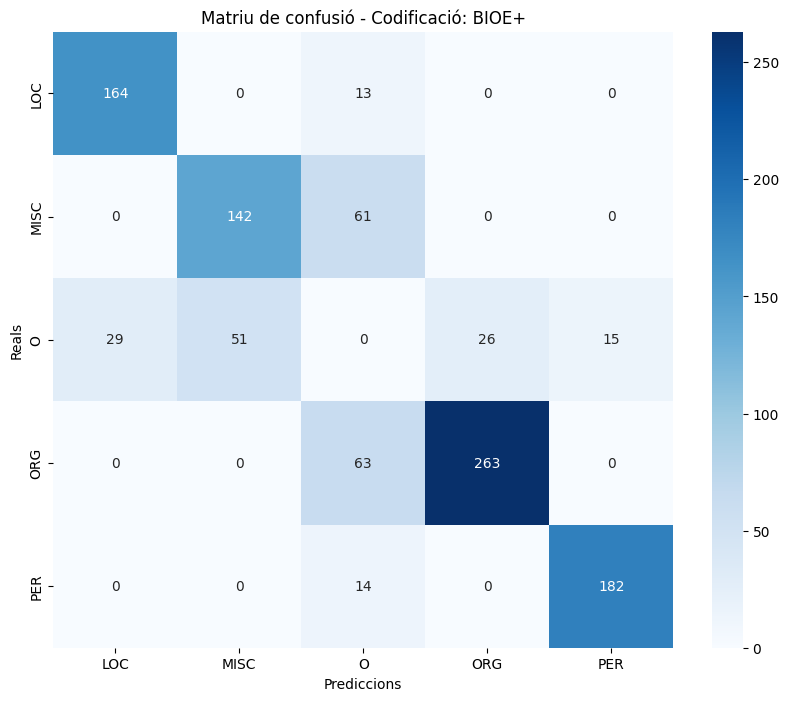

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir prediccions de la millor codificació
val_cod = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_es](sent)] for sent in dev_es]
preds = [tagger.tag(sent) for sent in val_cod]
preds_reconstructed = [[(tok, pos, tag) for ((tok, pos), tag) in frase] for frase in preds]
preds_bio = convert_to_bio(preds_reconstructed, best_coding_es)
preds_eval = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_bio]

# Convertir a tuples d’entitats (offsets)
pred_entities = extract_entities(preds_eval)
true_entities = extract_entities(real_tags_es)

# Aplanar entitats per comparar-les en base a les etiquetes
y_true = [ent[2] for ent in true_entities]
y_pred = []
for ent in true_entities:
    if ent in pred_entities:
        y_pred.append(ent[2])
    else:
        y_pred.append("O")  # Considerar com no reconeguda

# Completar prediccions que no estaven en y_true
for ent in pred_entities:
    if ent not in true_entities:
        y_true.append("O")
        y_pred.append(ent[2])

# Matriu de confusió
labels = sorted(list(set(y_true + y_pred)))
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Visualització
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title(f'Matriu de confusió - Codificació: {best_coding_es}')
plt.xlabel('Prediccions')
plt.ylabel('Reals')
plt.show()


La matriu de confusió mostra el rendiment del model per a cada tipus d'entitat quan s'utilitza la codificació `BIOE+`. Es pot observar el següent:

- **LOC** (localitzacions): observacions majoritàriament classificades correctament (**164** casos), amb pocs errors (13 entitats etiquetades incorrectament com `O`).
- **PER** (persones): rendiment molt sòlid, amb **182** encerts i només **14** casos no detectats (classificats com `O`).
- **ORG** (organitzacions): també es reconeixen molt bé (**263** encerts), tot i que apareixen **63** errors com a `O`, probablement degut a ambigüitats o a falta de context suficient.
- **MISC** (entitats diverses): és la categoria amb més confusions, especialment amb `O` (**51** casos) i amb altres entitats (**61** etiquetades erròniament com a MISC). Això indica que aquest tipus d'entitat és menys consistent i més difícil de delimitar.

- **Categoria `O`** (no entitat): hi ha força prediccions incorrectes aquí, especialment amb `MISC`, cosa que fa pensar que el model tendeix a confondre entitats poc freqüents o amb context difús amb paraules no rellevants.

**Conclusió:** el model mostra un comportament molt robust per a entitats ben definides com `LOC`, `ORG` i `PER`, però té dificultats per diferenciar entitats de tipus `MISC` i per evitar falsos negatius (prediccions com `O` que haurien d'haver estat etiquetades com a entitat). Aquesta informació pot ser clau per refinar la definició d’entitats o ajustar els gazetteers i el context.


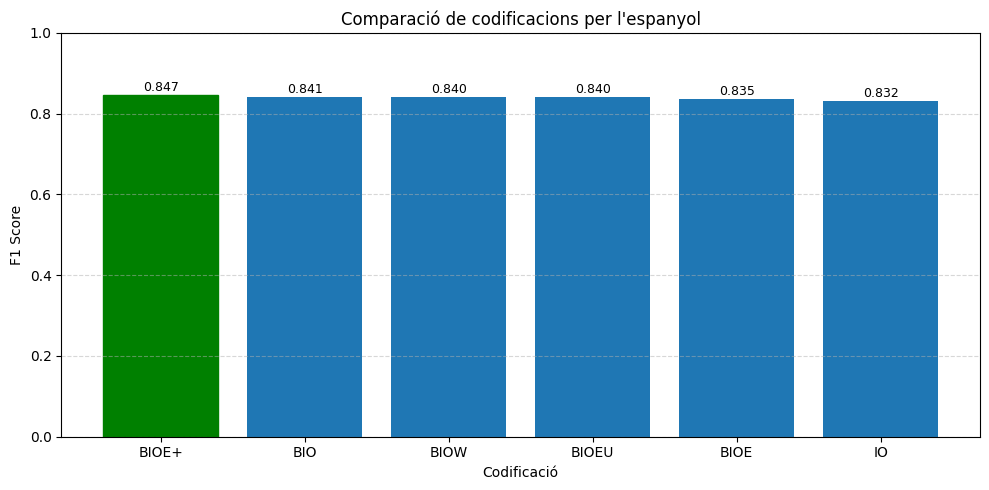

In [36]:
import matplotlib.pyplot as plt

# Separar noms i valors per graficar
codings = [r[0] for r in results_es]
f1_scores = [r[1] for r in results_es]

# Crear la gràfica
plt.figure(figsize=(10, 5))
bars = plt.bar(codings, f1_scores)

# Ressaltar el millor resultat en verd
best_index = f1_scores.index(max(f1_scores))
bars[best_index].set_color('green')

# Afegir etiquetes i títol
plt.xlabel("Codificació")
plt.ylabel("F1 Score")
plt.title("Comparació de codificacions per l'espanyol")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar valors numèrics sobre cada barra
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1 + 0.01, f"{f1:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


Aquest gràfic ofereix una manera visual de veure quin esquema d’etiquetatge ha funcionat millor. Tot i que les diferències són lleus, la codificació **BIOE+** destaca lleugerament per sobre de la resta, amb el millor F1. Això reforça la seva selecció com a millor opció per al model espanyol.

---

Igual que en el cas de l'espanyol, vam avaluar el rendiment del model en neerlandès utilitzant diferents codificacions d'etiquetatge. Per cada esquema (BIO, IO, BIOW, etc.), es converteixen les dades, s’entrena un model amb la millor configuració de *features* trobada, i s’avalua sobre el conjunt de validació. 

L’objectiu és identificar quina codificació ofereix el millor F1 score per al neerlandès.

In [37]:
# Preparar tags reals per a la validació (en format BIO per comparació)
real_tags_nl = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_nl]

# Resultats guardats
results_nl = []

# Iterar sobre codificacions
for cod in codificacions:
    print(f"\n\033[1mCodificació: {cod}\033[0m")

    # 1. Convertir dades d'entrenament i validació
    train_cod = [[((w, pos), tag) for (w, pos, tag) in codificacions[cod](sent)] for sent in train_nl]
    val_cod = [[(w, pos) for (w, pos, tag) in codificacions[cod](sent)] for sent in dev_nl]

    # 2. Entrenar model amb la millor configuració trobada
    feat_func = FeatFunc(**best_config_nl)
    tagger = CustomCRFTagger(feature_func=feat_func)
    tagger.train(train_cod, f"model_nl_{cod}.model")
    tagger.set_model_file(f"model_nl_{cod}.model")

    # 3. Fer prediccions
    preds = [tagger.tag(sent) for sent in val_cod]

    # 4. Reconstruir amb POS → ((tok, pos), tag) → (tok, pos, tag)
    preds_reconstructed = [[(tok, pos, tag) for ((tok, pos), tag) in frase] for frase in preds]

    # 5. Convertir a format BIO
    preds_bio = convert_to_bio(preds_reconstructed, cod)

    # 6. Passar a format [(token, tag)] per a l'avaluació
    preds_eval = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_bio]

    # 7. Avaluar amb la nova funció
    results = evaluate(real_tags_nl, preds_eval)
    f1_scores = get_f1s(results)

    # Triar F1 segons mode seleccionat
    if selection_mode == 'mixed':
        f1 = (f1_scores['exact'] + f1_scores['partial']) / 2
    else:
        f1 = f1_scores[selection_mode]

    # 8. Mostrar i guardar resultats
    print(f"→ F1 [exacte]: {f1_scores['exact']:.4f} | [parcial]: {f1_scores['partial']:.4f}")
    results_nl.append((cod, f1))

# Ordenar i trobar la millor codificació
results_nl.sort(key=lambda x: x[1], reverse=True)
print("\n\033[1mResultats ordenats per F1 (neerlandès):\033[0m")
for cod, f1 in results_nl:
    print(f"{cod}: {f1:.4f}")

millor_cod_nl = results_nl[0]
print(f"\n\033[1;32m→ Millor codificació: {millor_cod_nl[0]} amb F1 = {millor_cod_nl[1]:.4f} ({selection_mode})\033[0m")

best_coding_nl = millor_cod_nl[0]


Codificació: BIO
→ F1 [exacte]: 0.8530 | [parcial]: 0.9377

Codificació: IO
→ F1 [exacte]: 0.8373 | [parcial]: 0.9291

Codificació: BIOW
→ F1 [exacte]: 0.8389 | [parcial]: 0.9161

Codificació: BIOE
→ F1 [exacte]: 0.8440 | [parcial]: 0.9201

Codificació: BIOEU
→ F1 [exacte]: 0.8389 | [parcial]: 0.9161

Codificació: BIOE+
→ F1 [exacte]: 0.8507 | [parcial]: 0.9353

Resultats ordenats per F1 (neerlandès):
BIO: 0.8530
BIOE+: 0.8507
BIOE: 0.8440
BIOW: 0.8389
BIOEU: 0.8389
IO: 0.8373

→ Millor codificació: BIO amb F1 = 0.8530 (exact)


Tot i que les diferències són petites, **BIO** obté el millor F1 exacte, tot just per sobre de **BIOE+**, que també presenta un rendiment molt competitiu.

| Codificació | F1 (exacte) | F1 (parcial) |
|-------------|-------------|--------------|
| **BIO**     | **0.8530**  | 0.9377       |
| BIOE+       | 0.8507      | **0.9353**   |
| BIOE        | 0.8440      | 0.9201       |
| BIOW        | 0.8389      | 0.9161       |
| BIOEU       | 0.8389      | 0.9161       |
| IO          | 0.8373      | 0.9291       |

El bon rendiment del format **BIO** pot atribuir-se al fet que ofereix una codificació clara i suficientment expressiva per distingir l’inici de les entitats, sense introduir la complexitat addicional de formats com BIOE o BIOEU. En corpus com el neerlandès, on les entitats tenen estructures regulars i menys fragmentació, aquesta simplicitat pot facilitar l'aprenentatge del model i reduir errors d’assignació de límits.


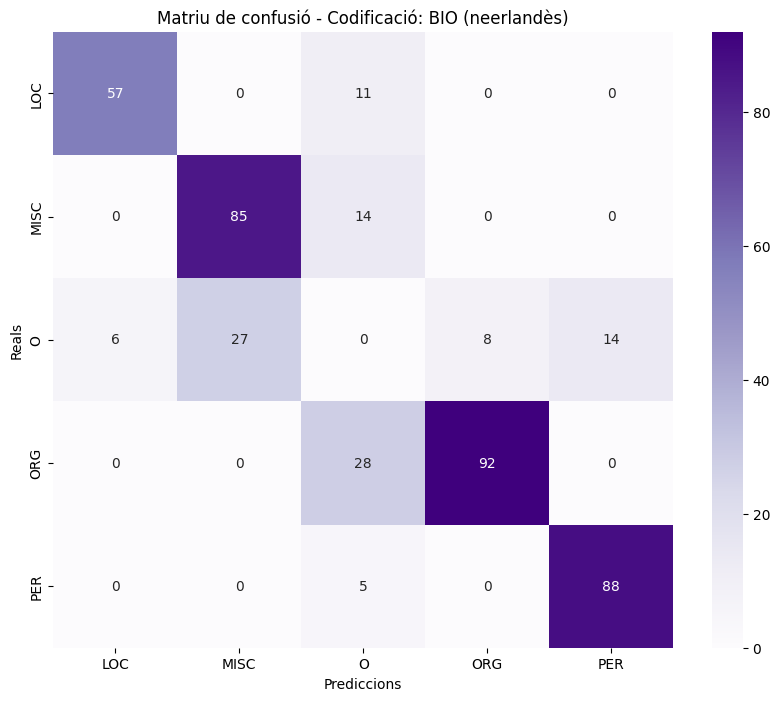

In [38]:
# Obtenir prediccions de la millor codificació per al neerlandès
val_cod_nl = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_nl](sent)] for sent in dev_nl]
preds_nl = [tagger.tag(sent) for sent in val_cod_nl]
preds_reconstructed_nl = [[(tok, pos, tag) for ((tok, pos), tag) in frase] for frase in preds_nl]
preds_bio_nl = convert_to_bio(preds_reconstructed_nl, best_coding_nl)
preds_eval_nl = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_bio_nl]

# Convertir a tuples d’entitats (offsets)
pred_entities_nl = extract_entities(preds_eval_nl)
true_entities_nl = extract_entities(real_tags_nl)

# Aplanar entitats per comparar-les en base a les etiquetes
y_true_nl = [ent[2] for ent in true_entities_nl]
y_pred_nl = []
for ent in true_entities_nl:
    if ent in pred_entities_nl:
        y_pred_nl.append(ent[2])
    else:
        y_pred_nl.append("O")  # Considerar com no reconeguda

# Completar prediccions que no estaven en y_true
for ent in pred_entities_nl:
    if ent not in true_entities_nl:
        y_true_nl.append("O")
        y_pred_nl.append(ent[2])

# Matriu de confusió
labels_nl = sorted(list(set(y_true_nl + y_pred_nl)))
cm_nl = confusion_matrix(y_true_nl, y_pred_nl, labels=labels_nl)

# Visualització
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nl, annot=True, fmt='d', xticklabels=labels_nl, yticklabels=labels_nl, cmap="Purples")
plt.title(f'Matriu de confusió - Codificació: {best_coding_nl} (neerlandès)')
plt.xlabel('Prediccions')
plt.ylabel('Reals')
plt.show()

La matriu de confusió mostra el comportament del model aplicat al neerlandès utilitzant la codificació BIO. Els resultats reflecteixen una capacitat alta per identificar correctament les entitats principals, però també revelen alguns punts crítics:

- **ORG** i **PER** són les entitats amb més encerts (92 i 88, respectivament), amb molt poques confusions.
- **MISC** també es classifica força bé (85 encerts), tot i que presenta algunes confusions amb la classe `O` (14 casos).
- **LOC** té 11 confusions amb `O`, cosa que pot indicar dificultat per reconèixer topònims en contextos ambigus o curts.
- La classe `O` mostra **27 casos mal classificats com a MISC** i **14 com a PER**, cosa que indica una certa tendència del model a sobreetiquetar com a entitat quan no cal.

**Conclusió:** el model generalment reconeix bé les entitats, però caldria vigilar especialment amb les falses positives (tokens no entitat classificats com a entitat), sobretot per a `MISC`, que sembla ser la classe més difícil de delimitar.


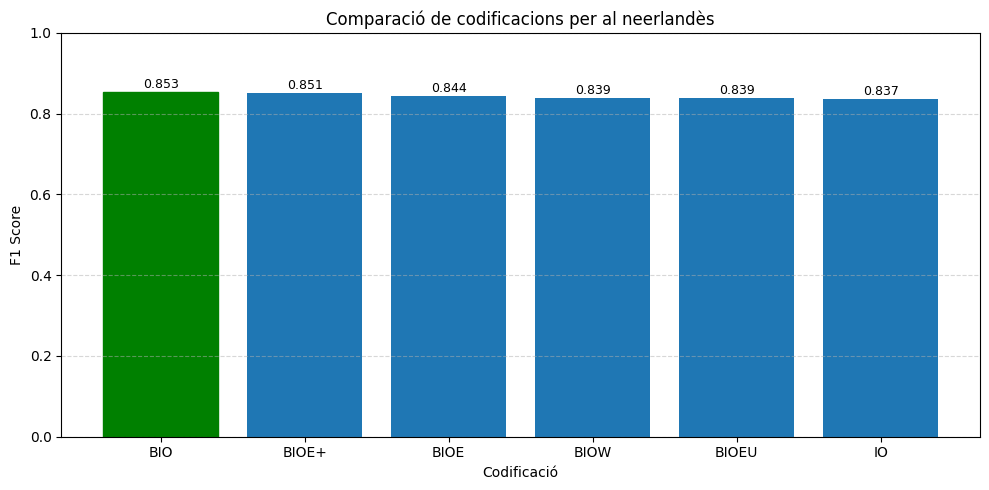

In [39]:
import matplotlib.pyplot as plt

# Separar noms i valors per graficar
codings_nl = [r[0] for r in results_nl]
f1_scores_nl = [r[1] for r in results_nl]

# Crear la gràfica
plt.figure(figsize=(10, 5))
bars_nl = plt.bar(codings_nl, f1_scores_nl)

# Ressaltar el millor resultat en verd
best_index_nl = f1_scores_nl.index(max(f1_scores_nl))
bars_nl[best_index_nl].set_color('green')

# Afegir etiquetes i títol
plt.xlabel("Codificació")
plt.ylabel("F1 Score")
plt.title("Comparació de codificacions per al neerlandès")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar valors numerats sobre cada barra
for i, f1 in enumerate(f1_scores_nl):
    plt.text(i, f1 + 0.01, f"{f1:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


En aquest gràfic podem veure de forma directa que les diferències entre esquemes són lleus, però aquesta visualització ens permet confirmar que **en aquest cas, una codificació simple com BIO és lleugerament més efectiva** que les variants més riques o complexes. Això pot ser degut a la regularitat en l'estructura de les entitats del corpus neerlandès.


## **6. Cerca d’Hiperparàmetres (c1, c2)**

Un cop definida la millor configuració de *features* (`best_config_esp`) i el millor esquema d’etiquetatge (`best_coding_es`), passem a optimitzar els **hiperparàmetres del model CRF**: els valors de regularització `c1` i `c2`.

Per fer-ho, entrenem diversos models amb combinacions dels valors definits per `c1` i `c2`, i avaluem el seu rendiment sobre el conjunt de validació. El millor parell d’hiperparàmetres es selecciona segons el criteri definit a `selection_mode`.

Aquesta cerca ens permet **ajustar finament el model** abans d’entrenar-lo definitivament amb els millors paràmetres.


In [40]:
from itertools import product
import pycrfsuite

# Funció per entrenar amb paràmetres usant pycrfsuite directament
def entrenar_amb_params(train_data, feat_func, model_path, c1=0.1, c2=0.1):
    """
    Entrena un model CRF amb pycrfsuite usant els hiperparàmetres c1 i c2.
    Guarda el model entrenat al path indicat.
    """
    trainer = pycrfsuite.Trainer(verbose=False)

    for frase in train_data:
        tokens = [tok for (tok, tag) in frase]
        tags = [tag for (tok, tag) in frase]
        feats = [feat_func(tokens, i) for i in range(len(tokens))]
        trainer.append(feats, tags)

    trainer.set_params({
        'c1': c1,
        'c2': c2,
        'max_iterations': 100,
        'feature.possible_transitions': True
    })

    trainer.train(model_path)

# Preparar les dades
train_data = [[((w, pos), tag) for (w, pos, tag) in codificacions[best_coding_es](sent)] for sent in train_es]
val_data = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_es](sent)] for sent in dev_es]
real_tags = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_es]

# Paràmetres a provar
c1_values = [0.01, 0.1, 0.5]
c2_values = [0.01, 0.1, 0.5]

# Variables per guardar resultats
millor_score = 0
millors_params = None
hp_results = []
feat_func = FeatFunc(**best_config_esp)

for c1, c2 in product(c1_values, c2_values):
    print(f"Provat amb c1={c1}, c2={c2}")
    
    # 1. Entrenar
    entrenar_amb_params(train_data, feat_func, "model_temp.model", c1=c1, c2=c2)

    # 2. Fer prediccions amb el model entrenat
    tagger = pycrfsuite.Tagger()
    tagger.open("model_temp.model")

    preds = []
    for sent in val_data:
        feats = [feat_func(sent, i) for i in range(len(sent))]
        tags = tagger.tag(feats)
        preds.append([(w, tag) for ((w, _), tag) in zip(sent, tags)])

    # 3. Convertir a format BIO si cal
    preds_bio = convert_to_bio([[ (w, 'X', tag) for (w, tag) in frase ] for frase in preds], best_coding_es)

    # 4. Reduir a (token, tag)
    preds_eval = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_bio]

    # 5. Avaluar
    results = evaluate(real_tags, preds_eval)
    f1_scores = get_f1s(results)

    # 6. Seleccionar el score segons el mode
    if selection_mode == 'mixed':
        score = (f1_scores['exact'] + f1_scores['partial']) / 2
    else:
        score = f1_scores[selection_mode]

    print(f"→ F1 [exacte]: {f1_scores['exact']:.4f} | [parcial]: {f1_scores['partial']:.4f} | → Score seleccionat: {score:.4f}")
    
    hp_results.append((c1, c2, score))

    if score > millor_score:
        millor_score = score
        millors_params = (c1, c2)

millor_f1_es = millor_score
print(f"\n\033[1;32mMillors hiperparàmetres trobats: c1={millors_params[0]}, c2={millors_params[1]}, F1 ({selection_mode}) = {millor_f1_es:.4f}\033[0m")


Provat amb c1=0.01, c2=0.01
→ F1 [exacte]: 0.8513 | [parcial]: 0.9512 | → Score seleccionat: 0.8513
Provat amb c1=0.01, c2=0.1
→ F1 [exacte]: 0.8533 | [parcial]: 0.9474 | → Score seleccionat: 0.8533
Provat amb c1=0.01, c2=0.5
→ F1 [exacte]: 0.8523 | [parcial]: 0.9474 | → Score seleccionat: 0.8523
Provat amb c1=0.1, c2=0.01
→ F1 [exacte]: 0.8511 | [parcial]: 0.9448 | → Score seleccionat: 0.8511
Provat amb c1=0.1, c2=0.1
→ F1 [exacte]: 0.8517 | [parcial]: 0.9393 | → Score seleccionat: 0.8517
Provat amb c1=0.1, c2=0.5
→ F1 [exacte]: 0.8511 | [parcial]: 0.9440 | → Score seleccionat: 0.8511
Provat amb c1=0.5, c2=0.01
→ F1 [exacte]: 0.8408 | [parcial]: 0.9428 | → Score seleccionat: 0.8408
Provat amb c1=0.5, c2=0.1
→ F1 [exacte]: 0.8451 | [parcial]: 0.9405 | → Score seleccionat: 0.8451
Provat amb c1=0.5, c2=0.5
→ F1 [exacte]: 0.8414 | [parcial]: 0.9404 | → Score seleccionat: 0.8414

Millors hiperparàmetres trobats: c1=0.01, c2=0.1, F1 (exact) = 0.8533


Els resultats mostren que els valors baixos de regularització, especialment **c1=0.01 i c2=0.1**, ofereixen el millor rendiment, amb un **F1 exacte de 0.8533** i un **F1 parcial de 0.9474**. 

Aquest comportament indica que el model es beneficia de regularitzacions suaus, que permeten aprofitar al màxim les *features* definides sense sobreajustar-se. En canvi, els valors més alts de `c1` i `c2` tendeixen a penalitzar massa les transicions i característiques, provocant una lleu pèrdua de rendiment.


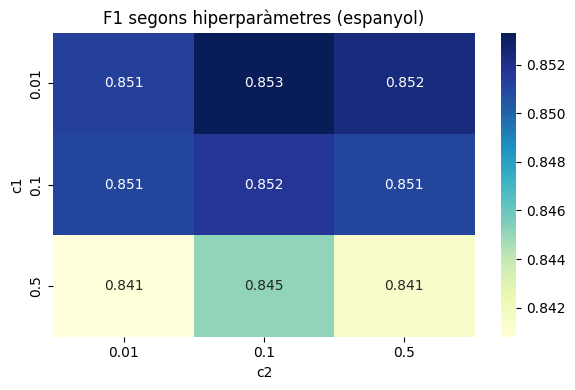

In [41]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Crear DataFrame i pivotar correctament
df_hp = pd.DataFrame(hp_results, columns=["c1", "c2", "f1"])
heatmap_data = df_hp.pivot(index="c1", columns="c2", values="f1")

# Crear gràfica
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("F1 segons hiperparàmetres (espanyol)")
plt.xlabel("c2")
plt.ylabel("c1")
plt.tight_layout()
plt.show()

Tal i com es pot veure en la matriu, el millor resultat s’obté amb **c1 = 0.01 i c2 = 0.1**, amb un F1 de **0.853**, just en la intersecció més fosca del mapa. Els valors elevats de `c1` (0.5) tendeixen a empitjorar lleugerament el rendiment global.
Aquesta visualització permet identificar fàcilment la combinació òptima i entendre com afecta la regularització al comportament del model.


--------------------------------------------------------------------------------------------------------------------------------------------------------------

Amb la millor configuració de *features* (`best_config_nl`) i la millor codificació d’etiquetes (`best_coding_nl`) ja definides, passem a optimitzar els hiperparàmetres `c1` i `c2` per al model en neerlandès.

Com abans, s’entrenen diversos models amb combinacions de valors possibles, i s’avaluen sobre el conjunt de validació. El millor parell es selecciona en funció de la mètrica especificada a `selection_mode`.

Aquesta fase permet afinar el model final específic per a la llengua neerlandesa.


In [42]:
# Prepara dades amb la millor codificació
train_data = [[((w, pos), tag) for (w, pos, tag) in codificacions[best_coding_nl](sent)] for sent in train_nl]
val_data = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_nl](sent)] for sent in dev_nl]
real_tags = [[(w, tag) for (w, pos, tag) in frase] for frase in dev_nl]

# Defineix valors a provar
c1_values = [0.01, 0.1, 0.5]
c2_values = [0.01, 0.1, 0.5]

# Variables de control
millor_score = 0
millors_params_nl = None
hp_results_nl = []
feat_func = FeatFunc(**best_config_nl)

# Bucle sobre totes les combinacions de c1 i c2
for c1, c2 in product(c1_values, c2_values):
    print(f"Provat amb c1={c1}, c2={c2}")
    
    # Entrenar model temporal
    entrenar_amb_params(train_data, feat_func, "model_temp_nl.model", c1=c1, c2=c2)

    # Carregar model
    tagger = pycrfsuite.Tagger()
    tagger.open("model_temp_nl.model")

    # Prediccions
    preds = []
    for sent in val_data:
        feats = [feat_func(sent, i) for i in range(len(sent))]
        tags = tagger.tag(feats)
        preds.append([(w, tag) for ((w, _), tag) in zip(sent, tags)])

    # Convertir a format BIO
    preds_bio = convert_to_bio([[ (w, 'X', tag) for (w, tag) in frase ] for frase in preds], best_coding_nl)

    # Reduir a format [(token, tag)]
    preds_eval = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_bio]

    # Avaluar
    results = evaluate(real_tags, preds_eval)
    f1_scores = get_f1s(results)

    if selection_mode == 'mixed':
        score = (f1_scores['exact'] + f1_scores['partial']) / 2
    else:
        score = f1_scores[selection_mode]

    print(f"→ F1 [exacte]: {f1_scores['exact']:.4f} | [parcial]: {f1_scores['partial']:.4f} | → Score seleccionat: {score:.4f}")

    hp_results_nl.append((c1, c2, score))

    if score > millor_score:
        millor_score = score
        millors_params_nl = (c1, c2)

millor_f1_nl = millor_score
print(f"\n\033[1;32mMillors hiperparàmetres NEERLANDÈS: c1={millors_params_nl[0]}, c2={millors_params_nl[1]}, F1 ({selection_mode}) = {millor_f1_nl:.4f}\033[0m")

Provat amb c1=0.01, c2=0.01
→ F1 [exacte]: 0.8568 | [parcial]: 0.9337 | → Score seleccionat: 0.8568
Provat amb c1=0.01, c2=0.1
→ F1 [exacte]: 0.8511 | [parcial]: 0.9354 | → Score seleccionat: 0.8511
Provat amb c1=0.01, c2=0.5
→ F1 [exacte]: 0.8624 | [parcial]: 0.9418 | → Score seleccionat: 0.8624
Provat amb c1=0.1, c2=0.01
→ F1 [exacte]: 0.8451 | [parcial]: 0.9344 | → Score seleccionat: 0.8451
Provat amb c1=0.1, c2=0.1
→ F1 [exacte]: 0.8500 | [parcial]: 0.9342 | → Score seleccionat: 0.8500
Provat amb c1=0.1, c2=0.5
→ F1 [exacte]: 0.8538 | [parcial]: 0.9381 | → Score seleccionat: 0.8538
Provat amb c1=0.5, c2=0.01
→ F1 [exacte]: 0.8508 | [parcial]: 0.9313 | → Score seleccionat: 0.8508
Provat amb c1=0.5, c2=0.1
→ F1 [exacte]: 0.8479 | [parcial]: 0.9441 | → Score seleccionat: 0.8479
Provat amb c1=0.5, c2=0.5
→ F1 [exacte]: 0.8493 | [parcial]: 0.9384 | → Score seleccionat: 0.8493

Millors hiperparàmetres NEERLANDÈS: c1=0.01, c2=0.5, F1 (exact) = 0.8624


El millor rendiment s’assoleix amb **c1 = 0.01 i c2 = 0.5**, obtenint un **F1 exacte de 0.8624** i un **F1 parcial de 0.9418**. 

Aquest resultat mostra que, en contrast amb l'espanyol, una **regularització forta sobre les característiques (`c2`)** i **molt suau sobre les transicions (`c1`)** és la combinació més efectiva per al neerlandès. Això podria indicar que el model necessita més flexibilitat per capturar variacions internes de les entitats, però un control més estricte sobre la complexitat de les *features*.


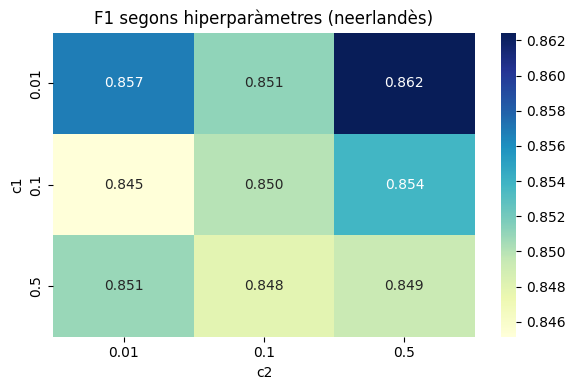

In [43]:
df_hp_nl = pd.DataFrame(hp_results_nl, columns=["c1", "c2", "f1"])
heatmap_data_nl = df_hp_nl.pivot(index="c1", columns="c2", values="f1")

plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data_nl, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("F1 segons hiperparàmetres (neerlandès)")
plt.xlabel("c2")
plt.ylabel("c1")
plt.tight_layout()
plt.show()

En aquesta representació podem veure que la millor puntuació (**0.862**) s’assoleix amb **c1 = 0.01 i c2 = 0.5**, que apareix destacada amb el color més fosc.
El patró general indica que:
- Valors baixos de `c1` (regularització suau de les transicions) afavoreixen el rendiment.
- `c2 = 0.5` (regularització forta de les *features*) sembla ser especialment útil en aquest model.

## **7. Entrenament del Model Final**

### **7.1. Entrenament i Guardat**

En aquest apartat hem dut a terme l'entrenament dels models finals per a cadascuna de les llengües, aplicant les millors configuracions obtingudes en la fase d'experimentació. Per a cada llengua, s'ha seleccionat la millor combinació de codificació d'etiquetes i de feature functions, així com els millors hiperparàmetres per a l'entrenament.

In [44]:
# Preparar les dades finals amb la millor codificació
train_final_es = [[((w, pos), tag) for (w, pos, tag) in codificacions[best_coding_es](sent)] for sent in train_es]
feat_func_final_es = FeatFunc(**best_config_esp)

# Entrenament amb pycrfsuite
trainer = pycrfsuite.Trainer(verbose=False)

for frase in train_final_es:
    tokens = [tok for (tok, tag) in frase]
    tags = [tag for (tok, tag) in frase]
    feats = [feat_func_final_es(tokens, i) for i in range(len(tokens))]
    trainer.append(feats, tags)

trainer.set_params({
    'c1': millors_params[0],
    'c2': millors_params[1],
    'max_iterations': 100,
    'feature.possible_transitions': True
})

# Entrenar i guardar
model_path_es = f"model_final_esp_{best_coding_es}.model"
trainer.train(model_path_es)

print(f"\n\033[1;32mModel final ESPANYOL guardat com {model_path_es}\033[0m")


Model final ESPANYOL guardat com model_final_esp_BIOE+.model


In [45]:
# Preparar les dades finals amb la millor codificació
train_final_nl = [[((w, pos), tag) for (w, pos, tag) in codificacions[best_coding_nl](sent)] for sent in train_nl]
feat_func_final_nl = FeatFunc(**best_config_nl)

# Entrenament amb pycrfsuite
trainer = pycrfsuite.Trainer(verbose=False)

for frase in train_final_nl:
    tokens = [tok for (tok, tag) in frase]
    tags = [tag for (tok, tag) in frase]
    feats = [feat_func_final_nl(tokens, i) for i in range(len(tokens))]
    trainer.append(feats, tags)

trainer.set_params({
    'c1': millors_params_nl[0],
    'c2': millors_params_nl[1],
    'max_iterations': 100,
    'feature.possible_transitions': True
})

# Entrenar i guardar
model_path_nl = f"model_final_nl_{best_coding_nl}.model"
trainer.train(model_path_nl)

print(f"\n\033[1;32mModel final NEERLANDÈS guardat com {model_path_nl}\033[0m")


Model final NEERLANDÈS guardat com model_final_nl_BIO.model


Aquest procés ens ha permès obtenir dos models CRF optimitzats i entrenats amb les millors condicions per a cada llengua, els quals estan llestos per ser utilitzats en la fase de test o aplicació a dades reals.

### **7.2. Avaluació Final sobre el Test**

Un cop entrenats els models finals amb les configuracions òptimes, hem procedit a avaluar el seu rendiment sobre els conjunts de test de cada llengua. L’avaluació s’ha fet tenint en compte les dues estratègies: considerant encerts les entitats totalment identificades, i considerant encerts parcials.

Per al model en espanyol, s’han seguit els passos següents: primer, s’ha codificat el conjunt de test amb la millor codificació (`best_coding_es`) i s’ha mantingut la configuració de features del model final. S’ha carregat el model desat i s’han generat les prediccions a partir de les features del test. Finalment, s’ha fet l’avaluació comparant les etiquetes reals amb les predites:

In [46]:
## ESPANYOL 
# Preparar el test amb la millor codificació
val_data_test_es = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_es](sent)] for sent in test_es]
real_tags_test_es = [[(w, tag) for (w, pos, tag) in frase] for frase in test_es]

# Fer prediccions amb el model final
# 1. Carrega el model amb pycrfsuite
tagger_final_es = pycrfsuite.Tagger()
tagger_final_es.open(model_path_es)

# 2. Fer prediccions (convertint a features)
preds_test_es = []
for sent in val_data_test_es:  # sent = [(token, pos), ...]
    feats = [feat_func_final_es(sent, i) for i in range(len(sent))]
    tags = tagger_final_es.tag(feats)
    preds_test_es.append([(tok, tag) for ((tok, _), tag) in zip(sent, tags)])

# 3. Avaluar
results_test_es = evaluate(real_tags_test_es, preds_test_es)
precision_test_es, recall_test_es, f1_test_es = results_test_es['exact']
precision_test_parcial_es, recall_test_parcial_es, f1_test_parcial_es = results_test_es['partial']

# 4. Mostrar resultats
print("\n\033[1mAvaluació FINAL sobre el TEST (ESPANYOL)\033[0m")
print(f"→ [Exactes]  Precision: {precision_test_es:.4f} | Recall: {recall_test_es:.4f} | F1: {f1_test_es:.4f}")
print(f"→ [Parcials] Precision: {precision_test_parcial_es:.4f} | Recall: {recall_test_parcial_es:.4f} | F1: {f1_test_parcial_es:.4f}")


Avaluació FINAL sobre el TEST (ESPANYOL)
→ [Exactes]  Precision: 0.8628 | Recall: 0.8331 | F1: 0.8477
→ [Parcials] Precision: 0.9555 | Recall: 0.9227 | F1: 0.9388


Els resultats obtinguts són molt positius. El model aconsegueix un **F1 de 0.8477** en **l’avaluació estricta**, la qual cosa indica que la majoria d'entitats s’han identificat completament. En **l’avaluació parcial**, el F1 puja fins a **0.9388**, confirmant que en molts casos, encara que no s’identifiqui l'entitat completa, sí que se’n detecta una part significativa. Això mostra que el model té una bona capacitat de reconeixement, tot i que en contextos més complexos pot fallar en la detecció exacta dels límits de les entitats.

El procés per al neerlandès ha estat idèntic: preparació del test amb la codificació òptima (`best_coding_nl`), aplicació de la feature function final, càrrega del model, predicció i avaluació. En aquest cas, però, calia convertir les prediccions al format BIO abans de l’avaluació per garantir la coherència amb les etiquetes reals:

In [47]:
# Preparar les dades de test amb la millor codificació
val_data_test_nl = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_nl](sent)] for sent in test_nl]
real_tags_test_nl = [[(w, tag) for (w, pos, tag) in frase] for frase in test_nl]

# Carregar model entrenat amb pycrfsuite
tagger_final_nl = pycrfsuite.Tagger()
tagger_final_nl.open(model_path_nl)

# Fer prediccions
preds_test_nl = []
for sent in val_data_test_nl:
    feats = [feat_func_final_nl(sent, i) for i in range(len(sent))]
    tags = tagger_final_nl.tag(feats)
    preds_test_nl.append([(tok, tag) for ((tok, _), tag) in zip(sent, tags)])

# Convertir a format BIO si cal
preds_test_nl_bio = convert_to_bio([[ (w, 'X', tag) for (w, tag) in frase ] for frase in preds_test_nl], best_coding_nl)

# Reduir a format [(token, tag)] per a l'avaluació
preds_test_nl_eval = [[(tok, tag) for (tok, pos, tag) in frase] for frase in preds_test_nl_bio]

# Avaluació
results_test_nl = evaluate(real_tags_test_nl, preds_test_nl_eval)
precision_test_nl, recall_test_nl, f1_test_nl = results_test_nl['exact']
precision_test_parcial_nl, recall_test_parcial_nl, f1_test_parcial_nl = results_test_nl['partial']

# Mostrar resultats
print("\n\033[1mAvaluació FINAL sobre el TEST (NEERLANDÈS)\033[0m")
print(f"→ [Exactes]  Precision: {precision_test_nl:.4f} | Recall: {recall_test_nl:.4f} | F1: {f1_test_nl:.4f}")
print(f"→ [Parcials] Precision: {precision_test_parcial_nl:.4f} | Recall: {recall_test_parcial_nl:.4f} | F1: {f1_test_parcial_nl:.4f}")


Avaluació FINAL sobre el TEST (NEERLANDÈS)
→ [Exactes]  Precision: 0.8828 | Recall: 0.8745 | F1: 0.8786
→ [Parcials] Precision: 0.9622 | Recall: 0.9532 | F1: 0.9577


El model per a neerlandès ha assolit un rendiment lleugerament superior en **l’avaluació estricta**, amb un F1 de **0.8786**, i molt alt en **l’avaluació parcial (0.9577)**. Això reflecteix que el model generalitza bé i detecta les entitats de forma molt precisa. La diferència entre les dues avaluacions és relativament petita, cosa que suggereix que sovint encerta tant les entitats com els seus límits.

**Conclusió de l'avaluació final en el test:**

Els dos models han mostrat un rendiment molt bo, amb F1 superiors al 0.84 en avaluació estricta i molt pròxims al 0.95 en avaluació parcial. El model de neerlandès ha destacat lleugerament per sobre del d’espanyol, possiblement degut a una combinació més efectiva entre codificació, features i paràmetres per a aquell corpus. En general, aquestes puntuacions indiquen que les decisions preses durant el procés d’enginyeria de features i selecció de codificació han estat encertades.

#### Gràfica comparativa dels idiomes 

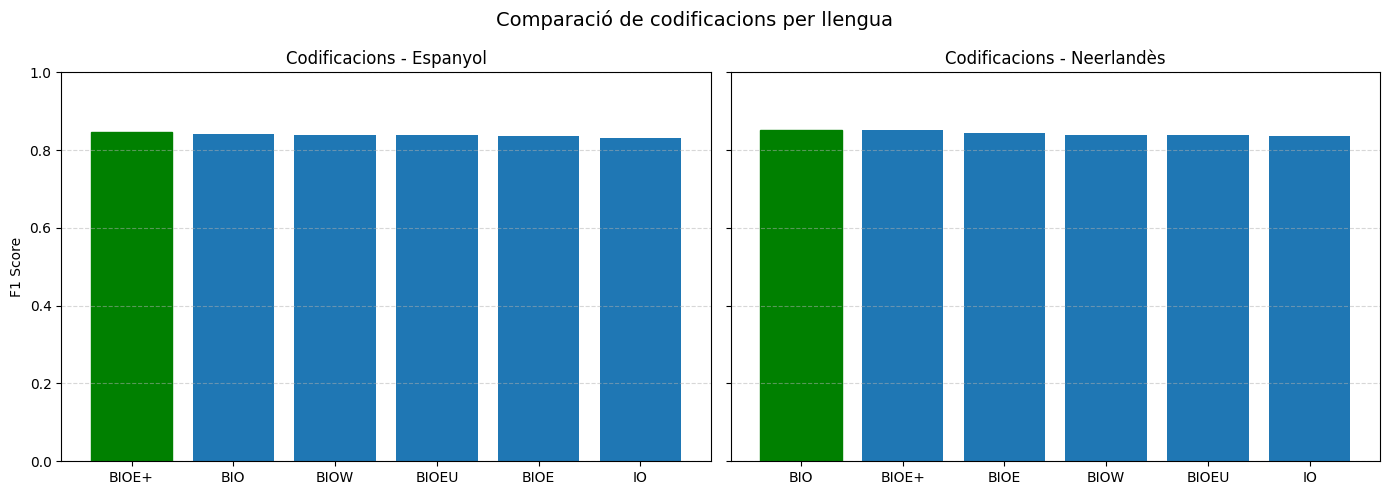

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# ESPANYOL
codings_es = [r[0] for r in results_es]
f1_scores_es = [r[1] for r in results_es]
bars_es = axs[0].bar(codings_es, f1_scores_es)
best_es = f1_scores_es.index(max(f1_scores_es))
bars_es[best_es].set_color('green')
axs[0].set_title("Codificacions - Espanyol")
axs[0].set_ylabel("F1 Score")
axs[0].set_ylim(0, 1)
axs[0].grid(axis='y', linestyle='--', alpha=0.5)

# NEERLANDÈS
codings_nl = [r[0] for r in results_nl]
f1_scores_nl = [r[1] for r in results_nl]
bars_nl = axs[1].bar(codings_nl, f1_scores_nl)
best_nl = f1_scores_nl.index(max(f1_scores_nl))
bars_nl[best_nl].set_color('green')
axs[1].set_title("Codificacions - Neerlandès")
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Comparació de codificacions per llengua", fontsize=14)
plt.tight_layout()
plt.show()

Aquest gràfic mostra una comparació de l'efecte de diferents codificacions d'entitats (BIO, BIOE, BIOEU, BIOW, BIOE+, IO) sobre el rendiment del model per a cada idioma (Espanyol i Neerlandès), a partir de la mètrica F1 (exacta). Cada barra representa la puntuació F1 assolida amb una codificació determinada. La barra en verd indica la millor codificació per a cada idioma.

En el cas de l'espanyol, la codificació BIOE+ és la que obté el millor resultat. Això pot ser degut a que aquesta codificació afegeix informació addicional sobre les entitats que NO formen part de cap entitat (amb etiquetes 'O' diferenciades), fet que pot ajudar el model a ser més precís en la detecció dels límits. Per contra, en el cas del neerlandès, la millor codificació és la tradicional BIO. Això podria indicar que la simplicitat d’aquesta codificació és més adequada per al corpus neerlandès o que altres codificacions introdueixen soroll.

En general, totes les codificacions obtenen resultats molt similars i competitius, però aquesta anàlisi mostra que petites variacions en la codificació poden tenir un impacte significatiu en el rendiment final. Per tant, la tria de codificació no s’ha de considerar trivial i convé experimentar-ne diverses segons el corpus i la llengua.


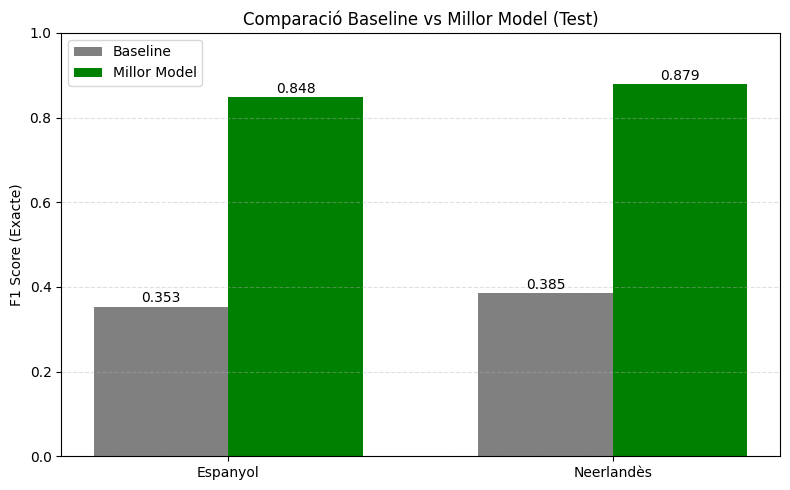

In [49]:
# Comparació Baseline vs Millor Model (TEST) per cada idioma
import matplotlib.pyplot as plt

idiomes = ['Espanyol', 'Neerlandès']
f1_baseline = [f1_baseline_es, f1_baseline_nl]
f1_millor = [f1_test_es, f1_test_nl]

x = range(len(idiomes))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, f1_baseline, width, label='Baseline', color='gray')
plt.bar([i + width for i in x], f1_millor, width, label='Millor Model', color='green')

plt.xticks([i + width / 2 for i in x], idiomes)
plt.ylabel('F1 Score (Exacte)')
plt.title('Comparació Baseline vs Millor Model (Test)')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Valors sobre les barres
for i in x:
    plt.text(i, f1_baseline[i] + 0.01, f"{f1_baseline[i]:.3f}", ha='center')
    plt.text(i + width, f1_millor[i] + 0.01, f"{f1_millor[i]:.3f}", ha='center')

plt.tight_layout()
plt.show()

Aquest gràfic mostra una comparació entre el model Baseline i el Millor Model per a la tasca de reconeixement d'entitats anomenades (NER) en el conjunt de test, tant per l'idioma espanyol com pel neerlandès.

L'eix vertical representa la puntuació F1 amb criteri d'exactitud, és a dir, només es comptabilitzen com a correctes aquelles entitats que han estat reconegudes exactament (mismatching parcial no compta).

Com es pot observar, el Millor Model supera clarament el baseline en ambdós idiomes:

- **En espanyol, es passa d'un F1 de 0.353 a 0.848**

- **En neerlandès, de 0.385 a 0.879**

Aquesta millora és resultat de la incorporació de funcions de *feature engineering* i l'ús de codificacions més precises, així com una millor selecció d'hiperparàmetres. Això demostra la importància de dissenyar bones funcions de característiques i codificacions adequades per a millorar la detecció precisa d'entitats.

## **8. Anàlisi dels Errors**
---

En aquest apartat es duu a terme un estudi detallat dels errors del model per a cada idioma i conjunt de dades (validació i test). L'objectiu és detectar patrons d'error habituals, identificar les entitats més problemàtiques i proposar millores concretes per optimitzar el rendiment del sistema de reconeixement d'entitats.

L'anàlisi es fa primer a partir del conjunt de validació (per observar com ha après el model), i posteriorment es valida amb el conjunt de test, per confirmar si es mantenen els mateixos punts febles en dades no vistes.

Per a cada idioma:
- Es compara el rendiment del baseline amb el del millor model obtingut.
- Es comptabilitzen els errors per tipus d’entitat.
- Es visualitzen els resultats en gràfics de barres.
- Finalment, es fa una comparació global entre idiomes per detectar diferències específiques de cada llengua.

Comparació amb el baseline – Espanyol
→ F1 Baseline [exacte]:  0.3532
→ F1 Baseline [parcial]: 0.5673
→ F1 Final    [exacte]:  0.8533
→ F1 Final    [parcial]: 0.9388

Errors per tipus d'entitat (espanyol):
LOC: 216
MISC: 191
PER: 273
ORG: 397


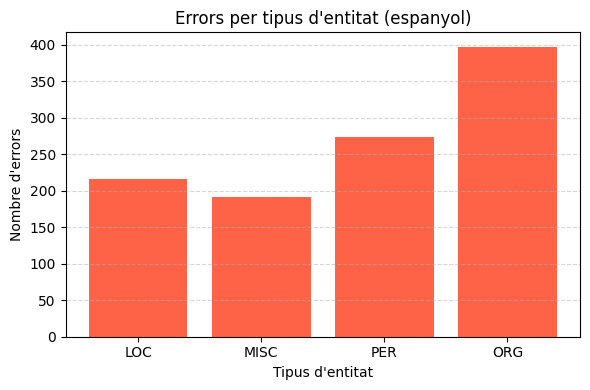

In [50]:
from collections import Counter
import matplotlib.pyplot as plt

# ESPANYOL

# 1. COMPARACIÓ AMB BASELINE
print("\033[1mComparació amb el baseline – Espanyol\033[0m")
print(f"→ F1 Baseline [exacte]:  {f1_baseline_es:.4f}")
print(f"→ F1 Baseline [parcial]: {f1_baseline_partial_es:.4f}")
print(f"→ F1 Final    [exacte]:  {millor_f1_es:.4f}")
print(f"→ F1 Final    [parcial]: {f1_test_parcial_es:.4f}")  # Assegura't que tens aquesta variable

# 2. ERROR ANALYSIS PER TIPUS D'ENTITAT
def get_entity_types(tags):
    return [tag[2:] for tag in tags if tag.startswith('B-')]

error_types = []

for real_sent, frase in zip(dev_es, val_data_es):
    real_tags = [tag for (_, _, tag) in real_sent]
    
    feats = [feat_func_final_es(frase, i) for i in range(len(frase))]
    pred_tags = tagger_final_es.tag(feats)
    
    if real_tags != pred_tags:
        errors = [r for r, p in zip(real_tags, pred_tags) if r != p and r != 'O']
        error_types.extend([e[2:] for e in errors if e.startswith('B-')])

# 3. COMPTAR I MOSTRAR ELS TIPUS D'ERRORS
error_counts = Counter(error_types)

print("\n\033[1mErrors per tipus d'entitat (espanyol):\033[0m")
if error_counts:
    for ent, count in error_counts.items():
        print(f"{ent}: {count}")
else:
    print("Cap error d'etiquetatge detectat.")

# 4. GRÀFICA D'ERRORS PER TIPUS
if error_counts:
    labels, values = zip(*error_counts.items())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color="tomato")
    plt.title("Errors per tipus d'entitat (espanyol)")
    plt.xlabel("Tipus d'entitat")
    plt.ylabel("Nombre d'errors")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

***Resultats en espanyol (validació)***

Comencem per l’anàlisi del model en espanyol aplicat al conjunt de validació. Els resultats mostren una millora significativa respecte del baseline:

- **F1 exacte:** de 0.3532 a 0.8533  
- **F1 parcial:** de 0.5673 a 0.9388

Aquesta millora reflecteix una millor detecció d’entitats i una segmentació més precisa. Per entendre millor on encara falla el model, s’han recollit els errors per tipus d’entitat, considerant només les etiquetes errònies que no són `O`.

El gràfic mostra que els errors es concentren principalment en:
- **ORG (397 errors):** sovint entitats compostes o amb noms comuns.
- **PER (273 errors):** habituals però amb ambigüitats amb llocs o organitzacions.
- **LOC i MISC (216 i 191 errors):** menys errors, potser per menor ambigüitat o freqüència.

Aquest patró d'errors ens ajuda a entendre quins aspectes del model caldria reforçar.

***Millores proposades***

A partir d’aquest anàlisi, es poden identificar estratègies per reforçar el rendiment, especialment en les entitats amb més errors:

- **Gazetteers:** llistes de noms coneguts (persones, llocs, organitzacions) com a feature binària.
- **Features morfològiques:** prefixos/sufixos, majúscules internes, longitud, POS-tags.
- **Regles heurístiques:** per corregir entitats trencades o encavalcades.
- **Codificacions alternatives:** com BIOE+ en el cas de l'espanyol, que ha mostrat bon rendiment.
- **Context ampliat:** consideració de tokens veïns per millorar la predicció.
- **Tractament d'entitats compostes:** especialment per casos d’ORG amb múltiples tokens.


Comparació amb el baseline – Neerlandès
→ F1 Baseline [exacte]:  0.3852
→ F1 Baseline [parcial]: 0.4889
→ F1 Final    [exacte]:  0.8624
→ F1 Final    [parcial]: 0.9577

Errors per tipus d'entitat (neerlandès):
MISC: 212
ORG: 351
LOC: 123
PER: 174


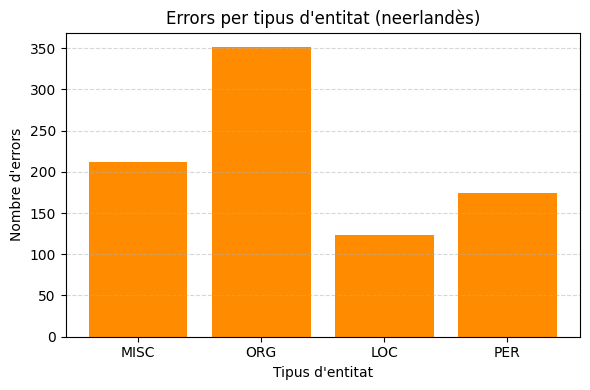

In [51]:
# NEERLANDÈS

# 1. COMPARACIÓ AMB BASELINE
print("\n\033[1mComparació amb el baseline – Neerlandès\033[0m")
print(f"→ F1 Baseline [exacte]:  {f1_baseline_nl:.4f}")
print(f"→ F1 Baseline [parcial]: {f1_baseline_partial_nl:.4f}")
print(f"→ F1 Final    [exacte]:  {millor_f1_nl:.4f}")
print(f"→ F1 Final    [parcial]: {f1_test_parcial_nl:.4f}")  # Assegura't que la tens definida

# 2. ERROR ANALYSIS PER TIPUS D'ENTITAT

error_types_nl = []

for real_sent, frase in zip(dev_nl, val_data_nl):
    real_tags = [tag for (_, _, tag) in real_sent]

    feats = [feat_func_final_nl(frase, i) for i in range(len(frase))]
    pred_tags = tagger_final_nl.tag(feats)

    if real_tags != pred_tags:
        errors = [r for r, p in zip(real_tags, pred_tags) if r != p and r != 'O']
        error_types_nl.extend([e[2:] for e in errors if e.startswith('B-')])

# 3. COMPTAR I MOSTRAR ELS TIPUS D'ERRORS
error_counts_nl = Counter(error_types_nl)

print("\n\033[1mErrors per tipus d'entitat (neerlandès):\033[0m")
if error_counts_nl:
    for ent, count in error_counts_nl.items():
        print(f"{ent}: {count}")
else:
    print("Cap error d'etiquetatge detectat.")

# 4. GRÀFICA D'ERRORS PER TIPUS
if error_counts_nl:
    labels, values = zip(*error_counts_nl.items())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color="darkorange")
    plt.title("Errors per tipus d'entitat (neerlandès)")
    plt.xlabel("Tipus d'entitat")
    plt.ylabel("Nombre d'errors")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

***Resultats en neerlandès (validació)***

S’aplica el mateix procés al model entrenat per al neerlandès. Els resultats també mostren una millora clara:

- **F1 exacte:** de 0.3852 a 0.8624  
- **F1 parcial:** de 0.4889 a 0.9577

Tot i l’alt rendiment, es detecten errors significatius en algunes entitats. Les més conflictives són:

- **ORG (351 errors):** entitats compostes o amb noms ambigus.
- **MISC (212 errors):** per la seva definició àmplia i poc estructurada.
- **PER i LOC (174 i 123 errors):** també amb cert grau d’ambigüitat.

Aquest comportament és semblant al vist en espanyol, però amb algunes diferències destacables.

***Propostes específiques per al neerlandès***

Tot i les semblances amb l'espanyol, les diferències en les distribucions d'errors justifiquen propostes més adaptades:

- **Gazetteers adaptats al neerlandès**, especialment per noms propis i localitzacions.
- **Millores morfològiques i contextuals**, incloent POS i capitalització.
- **Regles postprocessament**, per a casos d’entitats trencades.
- **Ajustos en la codificació**, BIO ha funcionat bé però es poden provar variants.
- **Millor tractament de MISC**, que ha resultat ser la categoria més problemàtica en aquest idioma.

Aquestes accions podrien reforçar la precisió del model en les àrees on ha mostrat més debilitat.



Errors per tipus d'entitat (ESPANYOL - TEST):
LOC: 1084
ORG: 1400
MISC: 339
PER: 735


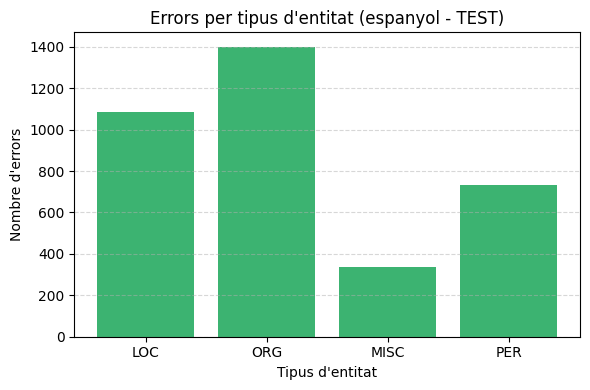

In [52]:
# ESPANYOL 

# 1. Preparar les dades
val_data_test_es = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_es](sent)] for sent in test_es]
real_tags_test_es = [[(w, tag) for (w, pos, tag) in frase] for frase in test_es]

# 2. Fer prediccions amb el model final
preds_test_es = [tagger_final_es.tag(sent) for sent in val_data_test_es]

# 3. Error analysis per tipus d'entitat
error_types_test_es = []

for real_sent, pred_tags in zip(test_es, preds_test_es):
    real_tags = [tag for (_, _, tag) in real_sent]

    if real_tags != pred_tags:
        errors = [r for r, p in zip(real_tags, pred_tags) if r != p and r != 'O']
        error_types_test_es.extend([e[2:] for e in errors if e.startswith('B-')])

error_counts_test_es = Counter(error_types_test_es)

# 4. Resultats i gràfica
print("\n\033[1mErrors per tipus d'entitat (ESPANYOL - TEST):\033[0m")
for ent, count in error_counts_test_es.items():
    print(f"{ent}: {count}")

if error_counts_test_es:
    labels, values = zip(*error_counts_test_es.items())
    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color="mediumseagreen")
    plt.title("Errors per tipus d'entitat (espanyol - TEST)")
    plt.xlabel("Tipus d'entitat")
    plt.ylabel("Nombre d'errors")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Cap error d'etiquetatge detectat al test.")

***Validació amb el conjunt de test (espanyol)***

Per tal de confirmar les tendències observades, s’ha repetit l’anàlisi amb el conjunt de test. Els resultats són consistents amb la validació:

- **ORG:** 1400 errors
- **LOC:** 1084 errors
- **PER:** 735 errors
- **MISC:** 339 errors

ORG continua sent la categoria amb més errors, i LOC i PER també presenten valors elevats. Això reforça la necessitat de millores específiques en aquestes entitats. La categoria MISC, en canvi, manté un comportament més estable i amb menys dificultat per al model.


Errors per tipus d'entitat (NEERLANDÈS - TEST):
LOC: 774
PER: 995
ORG: 880
MISC: 1187


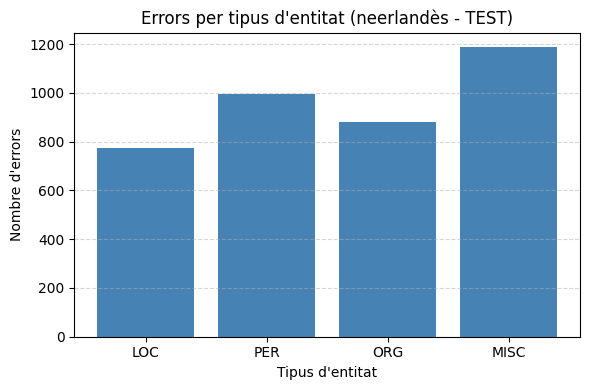

In [53]:
# NEERLANDES

# 1. Preparar les dades
val_data_test_nl = [[(w, pos) for (w, pos, tag) in codificacions[best_coding_nl](sent)] for sent in test_nl]
real_tags_test_nl = [[(w, tag) for (w, pos, tag) in frase] for frase in test_nl]

# 2. Fer prediccions amb el model final
preds_test_nl = [tagger_final_nl.tag(sent) for sent in val_data_test_nl]

# 3. Error analysis per tipus d'entitat
error_types_test_nl = []

for real_sent, pred_sent in zip(test_nl, preds_test_nl):
    real_tags = [tag for (_, _, tag) in real_sent]

    # Si pred_sent és una llista de tags simples (strings):
    if all(isinstance(t, str) for t in pred_sent):
        pred_tags = pred_sent
    # Si pred_sent són tuples (token, tag):
    elif all(isinstance(t, tuple) and len(t) == 2 for t in pred_sent):
        pred_tags = [tag for (_, tag) in pred_sent]
    # Si són tuples de 3 valors:
    elif all(isinstance(t, tuple) and len(t) == 3 for t in pred_sent):
        pred_tags = [tag for (_, _, tag) in pred_sent]
    else:
        raise ValueError(f"Format inesperat en pred_sent: {pred_sent[:3]}")

    if real_tags != pred_tags:
        errors = [r for r, p in zip(real_tags, pred_tags) if r != p and r != 'O']
        error_types_test_nl.extend([e[2:] for e in errors if e.startswith('B-')])

error_counts_test_nl = Counter(error_types_test_nl)

# 4. Resultats i gràfica
print("\n\033[1mErrors per tipus d'entitat (NEERLANDÈS - TEST):\033[0m")
for ent, count in error_counts_test_nl.items():
    print(f"{ent}: {count}")

if error_counts_test_nl:
    labels, values = zip(*error_counts_test_nl.items())
    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color="steelblue")
    plt.title("Errors per tipus d'entitat (neerlandès - TEST)")
    plt.xlabel("Tipus d'entitat")
    plt.ylabel("Nombre d'errors")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Cap error d'etiquetatge detectat al test.")

***Validació amb el conjunt de test (neerlandès)***

El model neerlandès també s'ha posat a prova sobre el test. L’anàlisi revela el següent:

- **MISC:** 1187 errors
- **PER:** 995 errors
- **ORG:** 880 errors
- **LOC:** 774 errors

En aquest cas, MISC és clarament la categoria més problemàtica. Això suggereix que en neerlandès, la diversitat i la manca de definició d’aquesta categoria afecten fortament la precisió. També es mantenen errors al voltant d’ORG i PER, en línia amb els resultats de validació.

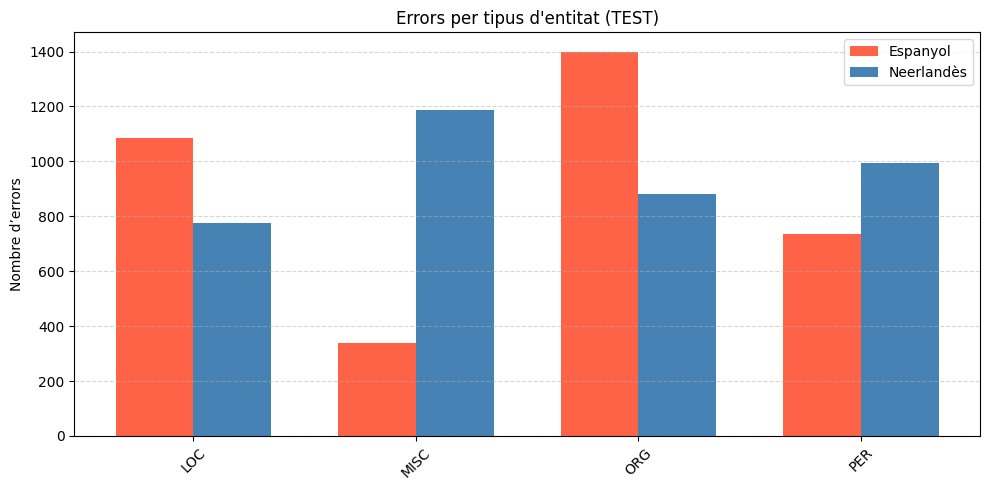

In [54]:
totes_entitats = set(error_counts_test_es.keys()) | set(error_counts_test_nl.keys())
entitats_ordenades = sorted(totes_entitats)

valors_es = [error_counts_test_es.get(e, 0) for e in entitats_ordenades]
valors_nl = [error_counts_test_nl.get(e, 0) for e in entitats_ordenades]

x = range(len(entitats_ordenades))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x, valors_es, width, label='Espanyol', color='tomato')
plt.bar([i + width for i in x], valors_nl, width, label='Neerlandès', color='steelblue')

plt.xticks([i + width / 2 for i in x], entitats_ordenades, rotation=45)
plt.ylabel('Nombre d’errors')
plt.title("Errors per tipus d'entitat (TEST)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

***Comparativa final entre idiomes***

Per cloure l’anàlisi, es presenta una comparativa directa entre els dos idiomes. El gràfic següent mostra el nombre total d’errors per tipus d’entitat en el conjunt de test.

Les conclusions clau són:

- **ORG** és la més problemàtica en espanyol, i també una font important d’errors en neerlandès.
- **MISC** destaca en neerlandès, mentre que en espanyol té un impacte molt menor.
- **PER** i **LOC** generen més errors en espanyol, però també són significatives en neerlandès.

Aquestes diferències posen de manifest la necessitat d’adaptar les estratègies de millora a cada idioma. Les tècniques generals (com més context o millor codificació) poden ajudar en tots dos casos, però cal combinar-les amb recursos específics com *gazetteers* per llengua o regles lingüístiques personalitzades.

## **9. Part Opcional: Model sobre el corpus CADEC**

En aquesta part opcional hem entrenat i avaluat un model de reconeixement d'entitats sobre el **corpus CADEC**, que conté textos clínics amb etiquetatge d'entitats com efectes adversos, malalties, fàrmacs, símptomes o descobriments.

Aquest corpus planteja un repte addicional respecte a la tasca principal: les **entitats sovint són més diverses, tècniques i específiques**, i el seu etiquetatge inclou **identificadors estandarditzats** (codi del concepte). Aquest fet introdueix una **gran variabilitat en les etiquetes** i fa més difícil el processament i la generalització.

A més, el corpus pot contenir **entitats discontínues**, un aspecte que **no es tracta en aquesta implementació**, però que en un entorn real representaria una dificultat extra per als models seqüencials com els CRF.

In [56]:
# Carregar dades CONLL
def carregar_conll(path):
    """
    Llegeix un fitxer en format CoNLL i retorna una llista de frases, 
    on cada frase és una llista de tuples (token, POS, etiqueta).
    El POS es fixa com a "X", ja que no està disponible al corpus CADEC.
    """
    dades = []
    frase = []

    with open(path, encoding="utf-8") as f:
        for linia in f:
            linia = linia.strip()
            if not linia or linia.startswith("LIPITOR."):
                if frase:
                    dades.append(frase)
                    frase = []
            else:
                parts = linia.split()
                if len(parts) >= 2:
                    token, tag = parts[0], parts[1]
                    frase.append((token, "X", tag))  # POS fictici: "X"
                else:
                    print(f"[AVÍS] Línia amb format inesperat: {linia}")

        if frase:
            dades.append(frase)

    print(f"Frases carregades des de {path}: {len(dades)}")
    return dades

train_cadec = carregar_conll("train.conll")
test_cadec = carregar_conll("test.conll")

[AVÍS] Línia amb format inesperat: PENNSAID.3
[AVÍS] Línia amb format inesperat: VOLTAREN.36
[AVÍS] Línia amb format inesperat: ARTHROTEC.36
[AVÍS] Línia amb format inesperat: VOLTAREN.2
[AVÍS] Línia amb format inesperat: VOLTAREN.18
[AVÍS] Línia amb format inesperat: ARTHROTEC.127
[AVÍS] Línia amb format inesperat: ARTHROTEC.68
[AVÍS] Línia amb format inesperat: CAMBIA.2
[AVÍS] Línia amb format inesperat: ARTHROTEC.75
[AVÍS] Línia amb format inesperat: DICLOFENAC-POTASSIUM.2
[AVÍS] Línia amb format inesperat: VOLTAREN-XR.22
[AVÍS] Línia amb format inesperat: ARTHROTEC.26
[AVÍS] Línia amb format inesperat: VOLTAREN.30
[AVÍS] Línia amb format inesperat: VOLTAREN-XR.7
[AVÍS] Línia amb format inesperat: ARTHROTEC.42
[AVÍS] Línia amb format inesperat: ARTHROTEC.128
[AVÍS] Línia amb format inesperat: ARTHROTEC.21
[AVÍS] Línia amb format inesperat: FLECTOR.1
[AVÍS] Línia amb format inesperat: VOLTAREN.3
[AVÍS] Línia amb format inesperat: ARTHROTEC.69
[AVÍS] Línia amb format inesperat: VOLTAR

In [57]:
# Simplificar etiquetes (BIO + tipus)
def simplifica_tags(dades):
    """
    Elimina l'identificador únic dels tags BIO del corpus CADEC i conserva només el tipus d'entitat (BIO-TIPUS).
    Per exemple, B-ADR:10033473 → B-ADR.
    """
    dades_simplificades = []
    for frase in dades:
        nova_frase = []
        for w, pos, tag in frase:
            if tag == 'O':
                nova_frase.append((w, pos, 'O'))
            else:
                parts = tag.split('-')
                if len(parts) == 2:
                    prefix, tipus = parts
                    tipus_simplificat = tipus.split(':')[0]  # Eliminar identificador
                    nova_frase.append((w, pos, f'{prefix}-{tipus_simplificat}'))
                else:
                    nova_frase.append((w, pos, 'O'))
        dades_simplificades.append(nova_frase)
    return dades_simplificades

train_cadec_simplificat = simplifica_tags(train_cadec)
test_cadec_simplificat = simplifica_tags(test_cadec)

In [58]:
# Definició de les features
feat_func_cadec = FeatFunc(
    use_word=True,
    use_upper=True,
    use_digit=True,
    use_suf=True,
    use_pref=True,
    use_context=True,
    use_len=True,
    use_pos=False,
    gazetteer=None
)

In [59]:
# Preparació de dades per a CRFsuite (format [(token, tag)])
def transforma_a_crfsuite(dades, feat_func):
    X = []
    y = []
    for frase in dades:
        tokens = [token for token, tag in frase]
        tags = [tag for token, tag in frase]
        feats = [feat_func(tokens, i) for i in range(len(tokens))]
        X.append(feats)
        y.append(tags)
    return X, y

# Convertir (amb train limitat per rapidesa)
train_sample_simple = [[(w, tag) for (w, pos, tag) in frase] for frase in train_cadec_simplificat[:300]]
test_sample_simple = [[(w, tag) for (w, pos, tag) in frase] for frase in test_cadec_simplificat]

X_train, y_train = transforma_a_crfsuite(train_sample_simple, feat_func_cadec)
X_test, y_test = transforma_a_crfsuite(test_sample_simple, feat_func_cadec)

### **Entrenament i avaluació del model**

S’ha entrenat un model CRF sobre una mostra de 300 frases del conjunt d’entrenament per tal de reduir el temps d’execució. 

Les dades s’han convertit al format necessari per a CRFsuite, utilitzant una funció de generació de *features* basada en:

- Informació lèxica (paraula)
- Majúscules, dígits
- Prefixos i sufixos
- Longitud de paraula
- Context (paraules veïnes)

Després, s’ha entrenat el model i s’ha fet la predicció sobre tot el conjunt de test.

In [60]:
# Entrenament del model
import pycrfsuite

trainer = pycrfsuite.Trainer(verbose=False)
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

trainer.set_params({
    'c1': 0.1,
    'c2': 0.1,
    'max_iterations': 30,
    'feature.possible_transitions': True
})

trainer.train("model_cadec_opcional.crfsuite")

In [61]:
# Predicció
tagger = pycrfsuite.Tagger()
tagger.open("model_cadec_opcional.crfsuite")
preds = [tagger.tag(xseq) for xseq in X_test]

In [62]:
# Avaluació a nivell d'entitats (no token)
def evaluate_tags(gold_seqs, pred_seqs):
    true = set()
    pred = set()

    for idx, (gseq, pseq) in enumerate(zip(gold_seqs, pred_seqs)):
        # Reals
        start = None
        entity_type = None
        for i, tag in enumerate(gseq):
            if tag.startswith('B-'):
                if start is not None:
                    true.add((idx, start, i-1, entity_type))
                start = i
                entity_type = tag[2:]
            elif tag == 'O':
                if start is not None:
                    true.add((idx, start, i-1, entity_type))
                    start = None
            elif tag.startswith('I-') and start is not None:
                continue
        if start is not None:
            true.add((idx, start, len(gseq)-1, entity_type))

        # Prediccions
        start = None
        entity_type = None
        for i, tag in enumerate(pseq):
            if tag.startswith('B-'):
                if start is not None:
                    pred.add((idx, start, i-1, entity_type))
                start = i
                entity_type = tag[2:]
            elif tag == 'O':
                if start is not None:
                    pred.add((idx, start, i-1, entity_type))
                    start = None
            elif tag.startswith('I-') and start is not None:
                continue
        if start is not None:
            pred.add((idx, start, len(pseq)-1, entity_type))

    correct = len(true & pred)
    precision = correct / len(pred) if pred else 0
    recall = correct / len(true) if true else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

precision, recall, f1 = evaluate_tags(y_test, preds)

print("\n\033[1mRESULTATS MODEL CADEC (opcional)\033[0m")
print(f"→ Precision: {precision:.4f}")
print(f"→ Recall:    {recall:.4f}")
print(f"→ F1 Score:  {f1:.4f}")


RESULTATS MODEL CADEC (opcional)
→ Precision: 0.5170
→ Recall:    0.1170
→ F1 Score:  0.1909


***Resultats d’avaluació***

L’avaluació s’ha fet a nivell d’entitat exacta (no de token), mitjançant comparació d’offsets d’entitats reals i predites.

Tot i que la **precisió** és relativament acceptable (el model tendeix a encertar quan prediu), el **recall** és molt baix, cosa que indica que s’estan escapant moltes entitats del text. Això es tradueix en una **puntuació F1 molt limitada**.

Aquest rendiment es pot atribuir a diversos factors:
- La gran **diversitat de codis d'entitat** (cada codi és una etiqueta diferent per al model).
- La **manca de normalització** (els codis no es relacionen semànticament entre ells).
- Les **poques dades d'entrenament** utilitzades (només 300 frases).
- L’**absència de tractament per entitats discontínues**.


Errors per tipus d'entitat (CADEC):
10013781: 2
10012805: 3
10041909: 1
10008479: 6
10033371: 73
10028836: 8
10043890: 25
10048973: 4
10011301: 9
10023614: 9
10018135: 3
10022004: 5
10023000: 5
10027599: 3
10033473: 15
10012378: 8
10022437: 6
0: 91
10016256: 19
10001949: 16
10027952: 6
10016825: 6
10042661: 3
10042076: 10
10018074: 9
10003993: 6
10046318: 6
10028294: 26
10006242: 1
10027313: 3
10028245: 2
10036097: 1
10028411: 35
10016974: 10
10003239: 23
10047810: 10
10024509: 1
10049681: 4
10013160: 1
10020765: 4
10065776: 2
10049278: 7
10047340: 7
10024419: 7
10047868: 9
10028350: 24
10023477: 12
10013968: 8
10013573: 7
10016336: 1
10011294: 3
10041017: 4
10005265: 9
10021706: 2
10029328: 4
10028289: 3
10033422: 5
10006784: 4
10010248: 4
10003731: 1
10034719: 1
10043882: 4
10047543: 6
10040982: 1
10003549: 17
10048971: 1
10011224: 8
10021527: 2
10008531: 2
10049565: 4
10041970: 3
10067673: 1
10018498: 1
10042772: 1
10020772: 2
10023567: 1
10059050: 1
10047896: 6
10034545: 1
1002442

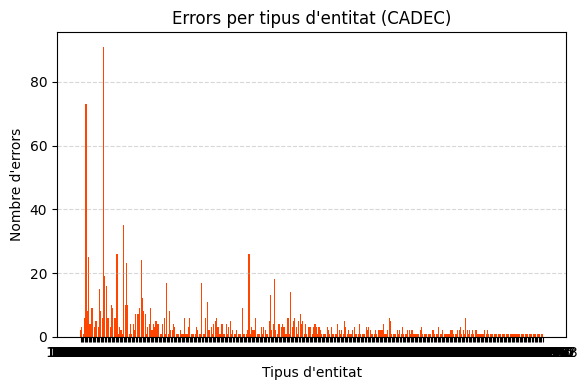

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

error_types = []

for gold, pred in zip(y_test, preds):
    for g_tag, p_tag in zip(gold, pred):
        if g_tag != p_tag and g_tag != 'O':
            error_types.append(g_tag[2:] if g_tag.startswith('B-') else None)

error_counts = Counter(t for t in error_types if t)

print("\n\033[1mErrors per tipus d'entitat (CADEC):\033[0m")
for ent, count in error_counts.items():
    print(f"{ent}: {count}")

if error_counts:
    labels, values = zip(*error_counts.items())
    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color="orangered")
    plt.title("Errors per tipus d'entitat (CADEC)")
    plt.xlabel("Tipus d'entitat")
    plt.ylabel("Nombre d'errors")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Cap error d'entitat detectat.")

***Anàlisi dels errors***

El gràfic següent mostra el nombre d’errors per etiqueta d’entitat. Cada barra correspon a un codi d’entitat del Knowledge Base CADEC. 

Com es pot veure, la majoria d’etiquetes tenen pocs errors, però algunes (com `0`, `10033371`, `10043890`, etc.) acumulen moltes confusions. Això pot indicar que:

- Hi ha **entitats molt freqüents** que el model no aconsegueix captar del tot.
- Alguns codis són **sistemàticament mal identificats**, possiblement perquè tenen molta variabilitat lèxica.
- El fet de **tractar cada codi com una classe diferent** pot no ser adequat per a conjunts d’entrenament petits, i potser caldria fer agrupacions més generals per tipus (ADR, DI, DR, S...).

Aquest tipus de problema és característic de la tasca amb el corpus CADEC, que introdueix **una dificultat superior** respecte a la tasca principal basada en NE tipus PER, LOC, ORG i MISC.
